In [1]:
import numpy as np
import pandas as pd
import Bio
from Bio import PDB
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
import matplotlib.pylab as plt
import matplotlib
import os
from os import listdir
from os.path import isfile, join, isdir
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 12})
rc('text', usetex=True)
import pandas as pd
from sklearn import metrics
from numpy.linalg import norm
from scipy.stats import spearmanr, pearsonr, kendalltau
import pickle
import re
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
import sklearn.metrics
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
from scipy.spatial import distance_matrix
%matplotlib inline

## Importing the local files I have written

import sys
sys.path.append('/Users/jakesumner/Documents/GitHub/PPI-graph_autoencoder/')

import create_protein_graph_structure
from create_protein_graph_structure import *

figure_save_dir = "/Users/jakesumner/OneDrive/Desktop/Yale CBB/OHern Lab/Rebuttal_data/Rebuttal_figures"

font_size = 16

In [50]:
print(list(ss_corr_df["pdb"]))

['1acb', '1ay7', '1c3a', '1euv', '1f60', '1ggp', '1itb', '1j7d', '1kfu', '1mbv', '1n1j', '1pdk', '1qav', '1r8o', '1ry7', '1spp', '1tfo', '1ugh', '1ugq', '1vet', '1wmh', '1wqj', '1wrd', '1xg2', '2bkr', '2d5r', '2dvw', '2fhz', '2g2u', '2grn', '2h7z', '2hla', '2hsm', '2hth', '2oul', '2pe6', '2wmp', '3dgp', '3fpn', '3gfk', '3hw2', '3k9p', '3ona', '3qc8', '3qhy', '3rcz', '3sgb', '3u82', '3vz9', '3wdg', '3whq', '3ygs', '4bi8', '4ct6', '4dbg', '4dhi', '4g6t', '4gi3', '4h5s', '4hwi', '4je3', '4k12', '4qjf', '4qlp', '4u1c', '4uzz', '4yii', '5by8', '5dmb', '5k7m', '5maw', '5mu7', '5uq2', '5zrz', '6fud', '6kp3', '6wg4', '6xod', '6yxj', '6zbk', '7bxh', '7joe', '7jxv', '8enf']


# Some basic functions for the code to run

In [2]:
def create_prob_dist_identical_bins(data, fig, ax, bins = [], n_bins = 100, color = "black", label = None, alpha = 1.0, marker = "o"):
    '''
    plots a probability distribution from the data provided
    '''
    if bins == []:
        bins = np.linspace(min(data),max(data),n_bins)
        bin_range = abs(bins[1]-bins[0])
        bins = np.array([min(bins)-bin_range] + list(bins) + [max(bins) + bin_range])
    
    n, bins, patches = ax.hist(data, bins=bins, density=True, histtype= "step", alpha = 0)
    bins = np.delete(bins, -1)
    bins += abs(bins[1]-bins[0])/2
    
    
    ax.plot(bins, n, marker=marker, color=color, markerfacecolor='none', label = label, alpha = alpha)
    
    x = np.array(bins)
    y = np.array(n)
    
    return x, y

# Load in the supersampled and nonsupersampled main datasets

In [3]:
os.chdir("/Users/jakesumner/Desktop/PPI Project/supersampling/final_manuscript_datasets")

ss_corr_df = pd.read_csv("supersampled_correlation_dataset_final_manuscript.csv")
relaxed_corr_df = pd.read_csv("non_supersampled_correlation_dataset_final_manuscript.csv")

In [4]:
## Load in the supersampled balanced dataset for each target

ss_balanced_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/all_supersampled_balanced_datasets"
os.chdir(ss_balanced_dir)

pdb_list = list(ss_corr_df["pdb"])

all_csv_files = sorted([f for f in listdir(ss_balanced_dir) if isfile(join(ss_balanced_dir, f)) and ".csv" in f and f[:4] in pdb_list])

ss_score_dict = {}
for csv_file in all_csv_files:
    pdb_name = csv_file[:4]
    ss_score_dict[pdb_name] = pd.read_csv(csv_file)

In [5]:
## Load in the pickle data

os.chdir("/Users/jakesumner/Desktop/PPI Project/")

with open("subsampling_400.pickle", "rb") as f:
    subsampling_400 = pickle.load(f)
    
with open("subsampling_200.pickle", "rb") as f:
    subsampling_200 = pickle.load(f)
    
with open("subsampling_100.pickle", "rb") as f:
    subsampling_100 = pickle.load(f)
    
with open("subsampling_50.pickle", "rb") as f:
    subsampling_50 = pickle.load(f)

### Non-supersampled original 500 Zdock run

In [6]:
not_supersampled_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/final_manuscript_all_unsupersampled_scores"
os.chdir(not_supersampled_dir)

all_csv_files = sorted([f for f in listdir(not_supersampled_dir) if isfile(join(not_supersampled_dir, f)) and ".csv" in f and f[:4] in pdb_list])

zdock_relaxed_combined_dfs = {}
for csv_file in all_csv_files:
    pdb_name = csv_file[:4]
    zdock_relaxed_combined_dfs[pdb_name] = pd.read_csv(csv_file)

## Load the exhaustive sampling data

In [9]:
exhaustive_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/exhaustive_all_targets"

os.chdir(exhaustive_dir)

exhaustive_corr_df = pd.read_csv("exhaustive_correlation_dataframe.csv")

exhaustive_score_dict = {}

csv_files = glob("*exhaustive_scores.csv")

for pdb_file in csv_files:
    pdb_name = pdb_file[:4]
    temp_df = pd.read_csv(pdb_file)
    
    exhaustive_score_dict[pdb_name] = temp_df


### Target Score Dataframe

In [10]:
os.chdir("/Users/jakesumner/Desktop/PPI Project/supersampling")

target_file = "all_89_target_scores.txt"

temp_dict = {
    "pdb" : [],
    "ZRank" : [],
    "HDOCK" : [],
    "Rosetta" : [],
    "PyDock" : [],
    "VoroMQA" : []
}

first = True
keys = list(temp_dict.keys())
with open(target_file, "r") as f:
    for line in f:
        if first:
            first = False
            continue
            
        temp_vals = line.split()
        for i in range(len(temp_vals)):
            try:
                temp_dict[keys[i]].append(float(temp_vals[i]))
            except:
                temp_dict[keys[i]].append(temp_vals[i])
            
f.close()

target_score_df = pd.DataFrame(temp_dict)

ones = np.ones((89))
target_score_df["DockQ"] = ones
target_score_df["IS-Score"] = ones

In [11]:
## Figure 2 data loading

os.chdir("/Users/jakesumner/Desktop/PPI Project/supersampling/final_manuscript_datasets")

fig_2_1xg2_df = pd.read_csv("1xg2_relaxed_unsupersampled_data.csv")

with open("dockq_distribution_not_ss_energy_minimized.pickle", "rb") as f:
    avg_dockq_bins_relax = pickle.load(f)
    
with open("dockq_distribution_ss_after_energy_minimization.pickle", "rb") as f:
    after_dockq_mean = pickle.load(f)
    
with open("dockq_distribution_ss_before_energy_minimization.pickle", "rb") as f:
    before_dockq_mean = pickle.load(f)

# Precision Recall instead of ROC Curve

In [14]:
## Create mask for the precision recall curve based on "true positives"

from scipy import integrate

def create_dockq_mask(model_df, dockq_cutoff = 0.23):
    '''
    Creates a mask for the score_col of the model_df
    based on the DockQ cutoff
    '''
    
    binary_mask = np.where(model_df["DockQ"] >= dockq_cutoff, 1, 0)
    
    return binary_mask

def get_precision_recall_curve(model_df, score_col = "ZRank", dockq_cutoff = 0.23, factor = -1):
    '''
    Gets the precision-recall curve for the model_df based on the score_col and 
    the given DockQ cutoff
    '''
    
    target_mask = create_dockq_mask(model_df, dockq_cutoff = dockq_cutoff)
    
    prec, recall, thresh = precision_recall_curve(target_mask, model_df[score_col]*factor)
    
    return prec, recall

def generate_all_precision_recall_curves(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the precision-recall
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
            
            temp_prec, temp_recall = get_precision_recall_curve(model_dict[pdb_name], score_col = score_col, dockq_cutoff = dockq_cutoff, factor = factor)
            
            ## Getting the AUC
            sort_ind = np.argsort(temp_recall)
            sort_prec = temp_prec[sort_ind]
            sort_recall = temp_recall[sort_ind]
            temp_auc = integrate.trapz(x = sort_recall, y = sort_prec)
            
            temp_pdb_dict[score_col] = [temp_auc, temp_recall, temp_prec]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

In [15]:
## ROC Curve Code

def get_indiv_ROC_curve(score_df, col_name = "ZRank", dockq_cutoff = 0.23, factor = -1):
    '''
    Simply aggregates all the score and label data across all targets in a dataframe and 
    then turns them into ROC curve data
    '''
    
    temp_mask, temp_scores = create_ROC_data_struc_dockq(score_df, col_name = col_name, dockq_cutoff = dockq_cutoff)
    roc_curve = metrics.roc_curve(temp_mask, factor*np.array(temp_scores), pos_label=1)
    roc_auc = metrics.roc_auc_score(temp_mask, factor*np.array(temp_scores))
    
    return roc_curve, roc_auc

def create_ROC_data_struc_dockq(score_df, col_name = "ZRank", dockq_cutoff = 0.23):
    '''
    Takes the score_df (DataFrame) and a given 'col_name' which corresponds to one of the columns 
    in the dataframe and some quality metric, which is what treats the data as a true positive. 
    True positives are labeled with a 1 and false positives are labeled with a 0.
    '''
    
    temp_scores = score_df[col_name]
    temp_dockq = score_df["DockQ"]
    
    ## Get the label array for the capri scores
    score_mask = np.zeros(temp_dockq.size)
    temp_dockq = list(temp_dockq)
    for i in range(len(score_mask)):
#         print(temp_dockq[i])
        if temp_dockq[i] >= dockq_cutoff:
            score_mask[i] = 1
    
    return score_mask, temp_scores

def generate_all_roc_data(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the ROC
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
            
            (fpr, tpr, thresh), temp_auc = get_indiv_ROC_curve(model_dict[pdb_name], col_name = score_col, dockq_cutoff = dockq_cutoff, factor = factor)
            
            temp_pdb_dict[score_col] = [temp_auc, fpr, tpr]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

## Precision-recall vs AUC for Uniformly Sampled data

In [16]:
## Get the precision_recall_data and ROC data

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

prec_recall_dict = generate_all_precision_recall_curves(pdb_list, ss_score_dict, score_list)
roc_dict = generate_all_roc_data(pdb_list, ss_score_dict, score_list)

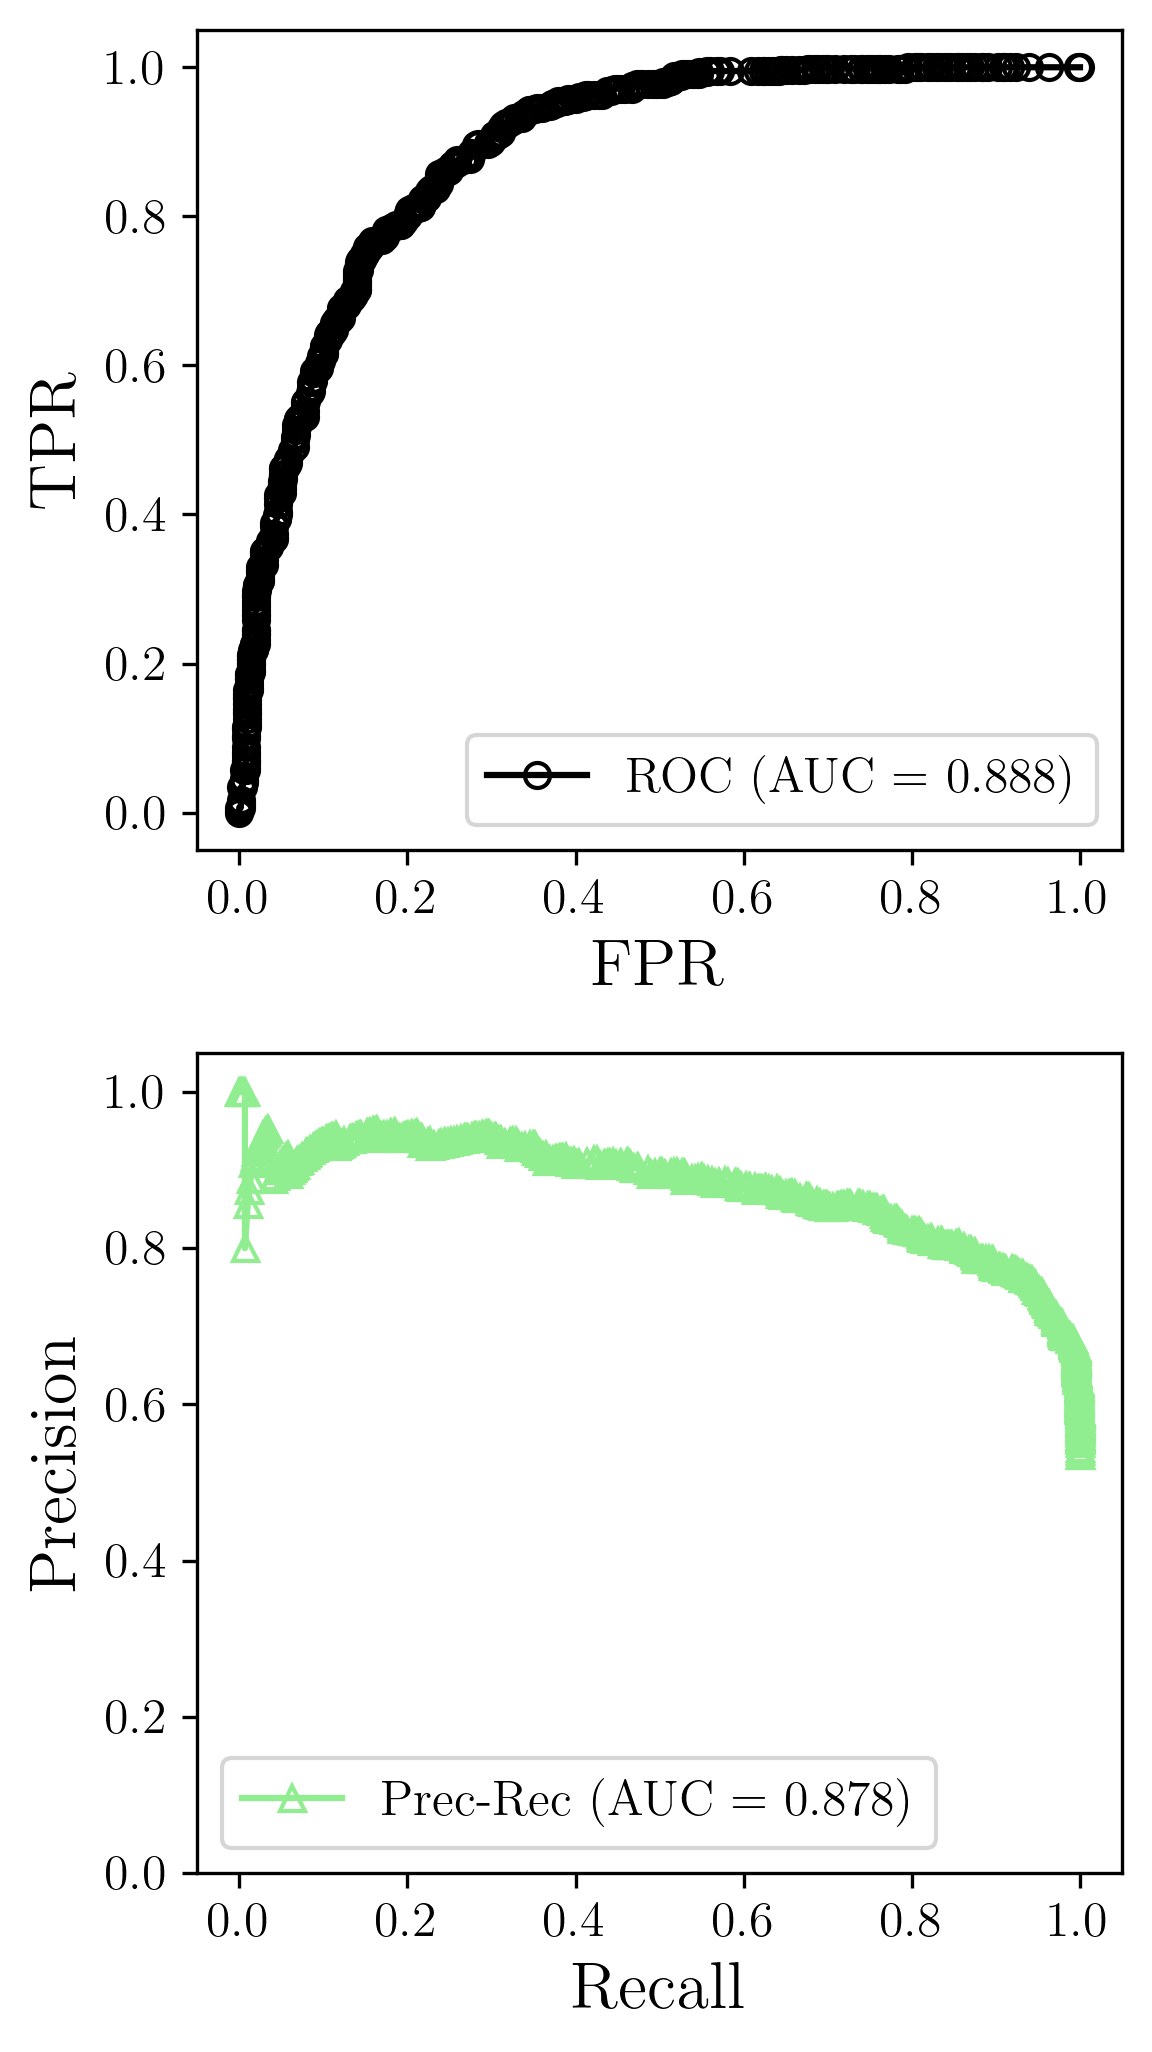

In [24]:
## Look at a few simple cases

pdb_name = "4u1c"

score_col = "Deeprank_gnn_esm"

roc_auc, roc_x, roc_y = roc_dict[pdb_name][score_col]

pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]

fig,ax = plt.subplots(2, 1,figsize = (4,7), dpi = 300)


## ROC Curve plot
ax[0].plot(roc_x, roc_y, color = "black", marker = "o", markerfacecolor = "None", label = f"ROC (AUC = {roc_auc:0.3f})")

## Precision-Recall Curve
ax[1].plot(pr_x, pr_y, color = "lightgreen", marker = "^", markerfacecolor = "None", label = f"Prec-Rec (AUC = {pr_auc:0.3f})")


fontsize = 16
ax[0].set_xlabel("FPR", fontsize = fontsize)
ax[0].set_ylabel("TPR", fontsize = fontsize)

ax[1].set_xlabel("Recall", fontsize = fontsize)
ax[1].set_ylabel("Precision", fontsize = fontsize)

ax[1].set_ylim([0,1.05])

ax[0].legend()
ax[1].legend()

fig.tight_layout()


## Save the plot to a file
plt.savefig(join(figure_save_dir,"single_PR_vs_ROC_4u1c.png"))

In [25]:
## Look at the average delta AUC in the precision-recall vs ROC for each scoring function!

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]


delta_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
        
        roc_auc, roc_x, roc_y = roc_dict[pdb_name][score_col]

        pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]
        
        delta_dict[score_col].append(pr_auc - roc_auc)
        



Avg |Delta| for ZRank2: 	 0.5764; 	 stdev:  0.2209
Avg |Delta| for ITScorePP: 	 0.5718; 	 stdev:  0.2035
Avg |Delta| for Rosetta: 	 0.5335; 	 stdev:  0.1383
Avg |Delta| for PyDock: 	 0.6035; 	 stdev:  0.2034
Avg |Delta| for VoroMQA: 	 0.6552; 	 stdev:  0.1721
Avg |Delta| for GNN-DOVE: 	 0.5714; 	 stdev:  0.2259
Avg |Delta| for Deeprank-GNN-ESM: 	 0.6366; 	 stdev:  0.1775


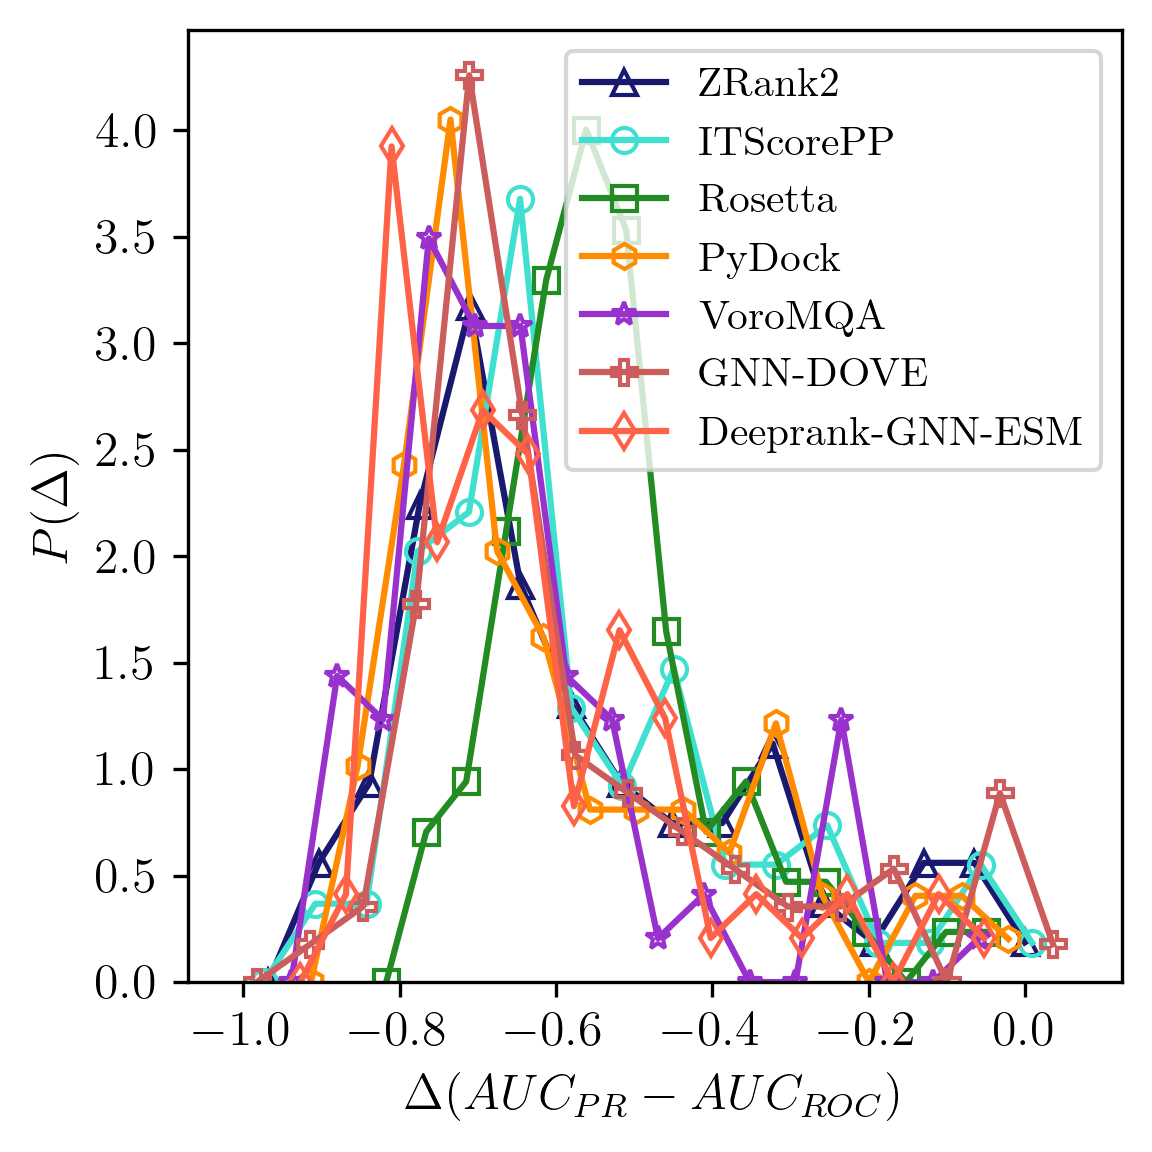

In [70]:
## Plot the deltas on the same plot

fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

nbins = 15

for i,score_col in enumerate(score_list):
    
    x = create_prob_dist_identical_bins(delta_dict[score_col], fig, ax, color = colors[i],
                                        marker = markers[i], label = actual_names[i], n_bins = nbins)
    
    print(f"Avg |Delta| for {actual_names[i]}: \t{np.mean(np.abs(delta_dict[score_col])): 0.4f}; \t stdev: {np.std(np.abs(delta_dict[score_col])): 0.4f}")
    
ax.set_xlabel("$\Delta (AUC_{PR} - AUC_{ROC})$")
ax.set_ylabel("$P(\Delta)$")

ax.legend(fontsize = 10)

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"Delta_AUCpr_AUCroc_uniform.png"))

## Precision-recall vs AUC for exhaustively sampled data

In [28]:
def generate_all_roc_data_ex(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the ROC
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
                
            try:
            
                (fpr, tpr, thresh), temp_auc = get_indiv_ROC_curve(model_dict[pdb_name], col_name = score_col, dockq_cutoff = dockq_cutoff, factor = factor)

                temp_pdb_dict[score_col] = [temp_auc, fpr, tpr]
                
            except:
                
                print(pdb_name, score_col)
                temp_pdb_dict[score_col] = [0, -1, -1]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

def generate_all_precision_recall_curves_ex(pdb_list, model_dict, score_list, dockq_cutoff = 0.23):
    '''
    Returns a dictionary with all the precision-recall
    curves for each target in the pdb list, also with each score in the 
    score list. DockQ_cutoff = 0.23 unless otherwise stated. 
    '''
    
    final_targ_dict = {}
    
    pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]
    
    for pdb_name in pdb_list:
        
        temp_pdb_dict = {}
        
        for score_col in score_list:
            
            if score_col in pos_factor_list:
                factor = 1
                
            else:
                factor = -1
                
            try:
            
                temp_prec, temp_recall = get_precision_recall_curve(model_dict[pdb_name], score_col = score_col, dockq_cutoff = dockq_cutoff, factor = factor)

                ## Getting the AUC
                sort_ind = np.argsort(temp_recall)
                sort_prec = temp_prec[sort_ind]
                sort_recall = temp_recall[sort_ind]
                temp_auc = integrate.trapz(x = sort_recall, y = sort_prec)

                temp_pdb_dict[score_col] = [temp_auc, temp_recall, temp_prec]
                
            except:
                print(pdb_name, score_col)
                temp_pdb_dict[score_col] = [0, -1, -1]
            
        final_targ_dict[pdb_name] = temp_pdb_dict
        
    return final_targ_dict

In [29]:
## Get the precision_recall_data and ROC data

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

prec_recall_dict_ex = generate_all_precision_recall_curves_ex(pdb_list, exhaustive_score_dict, score_list)
roc_dict_ex = generate_all_roc_data_ex(pdb_list, exhaustive_score_dict, score_list)

/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/

5by8 ZRank
5by8 itscorepp
5by8 Rosetta
5by8 PyDock
5by8 VoroMQA
5by8 Dove_5
5by8 Deeprank_gnn_esm


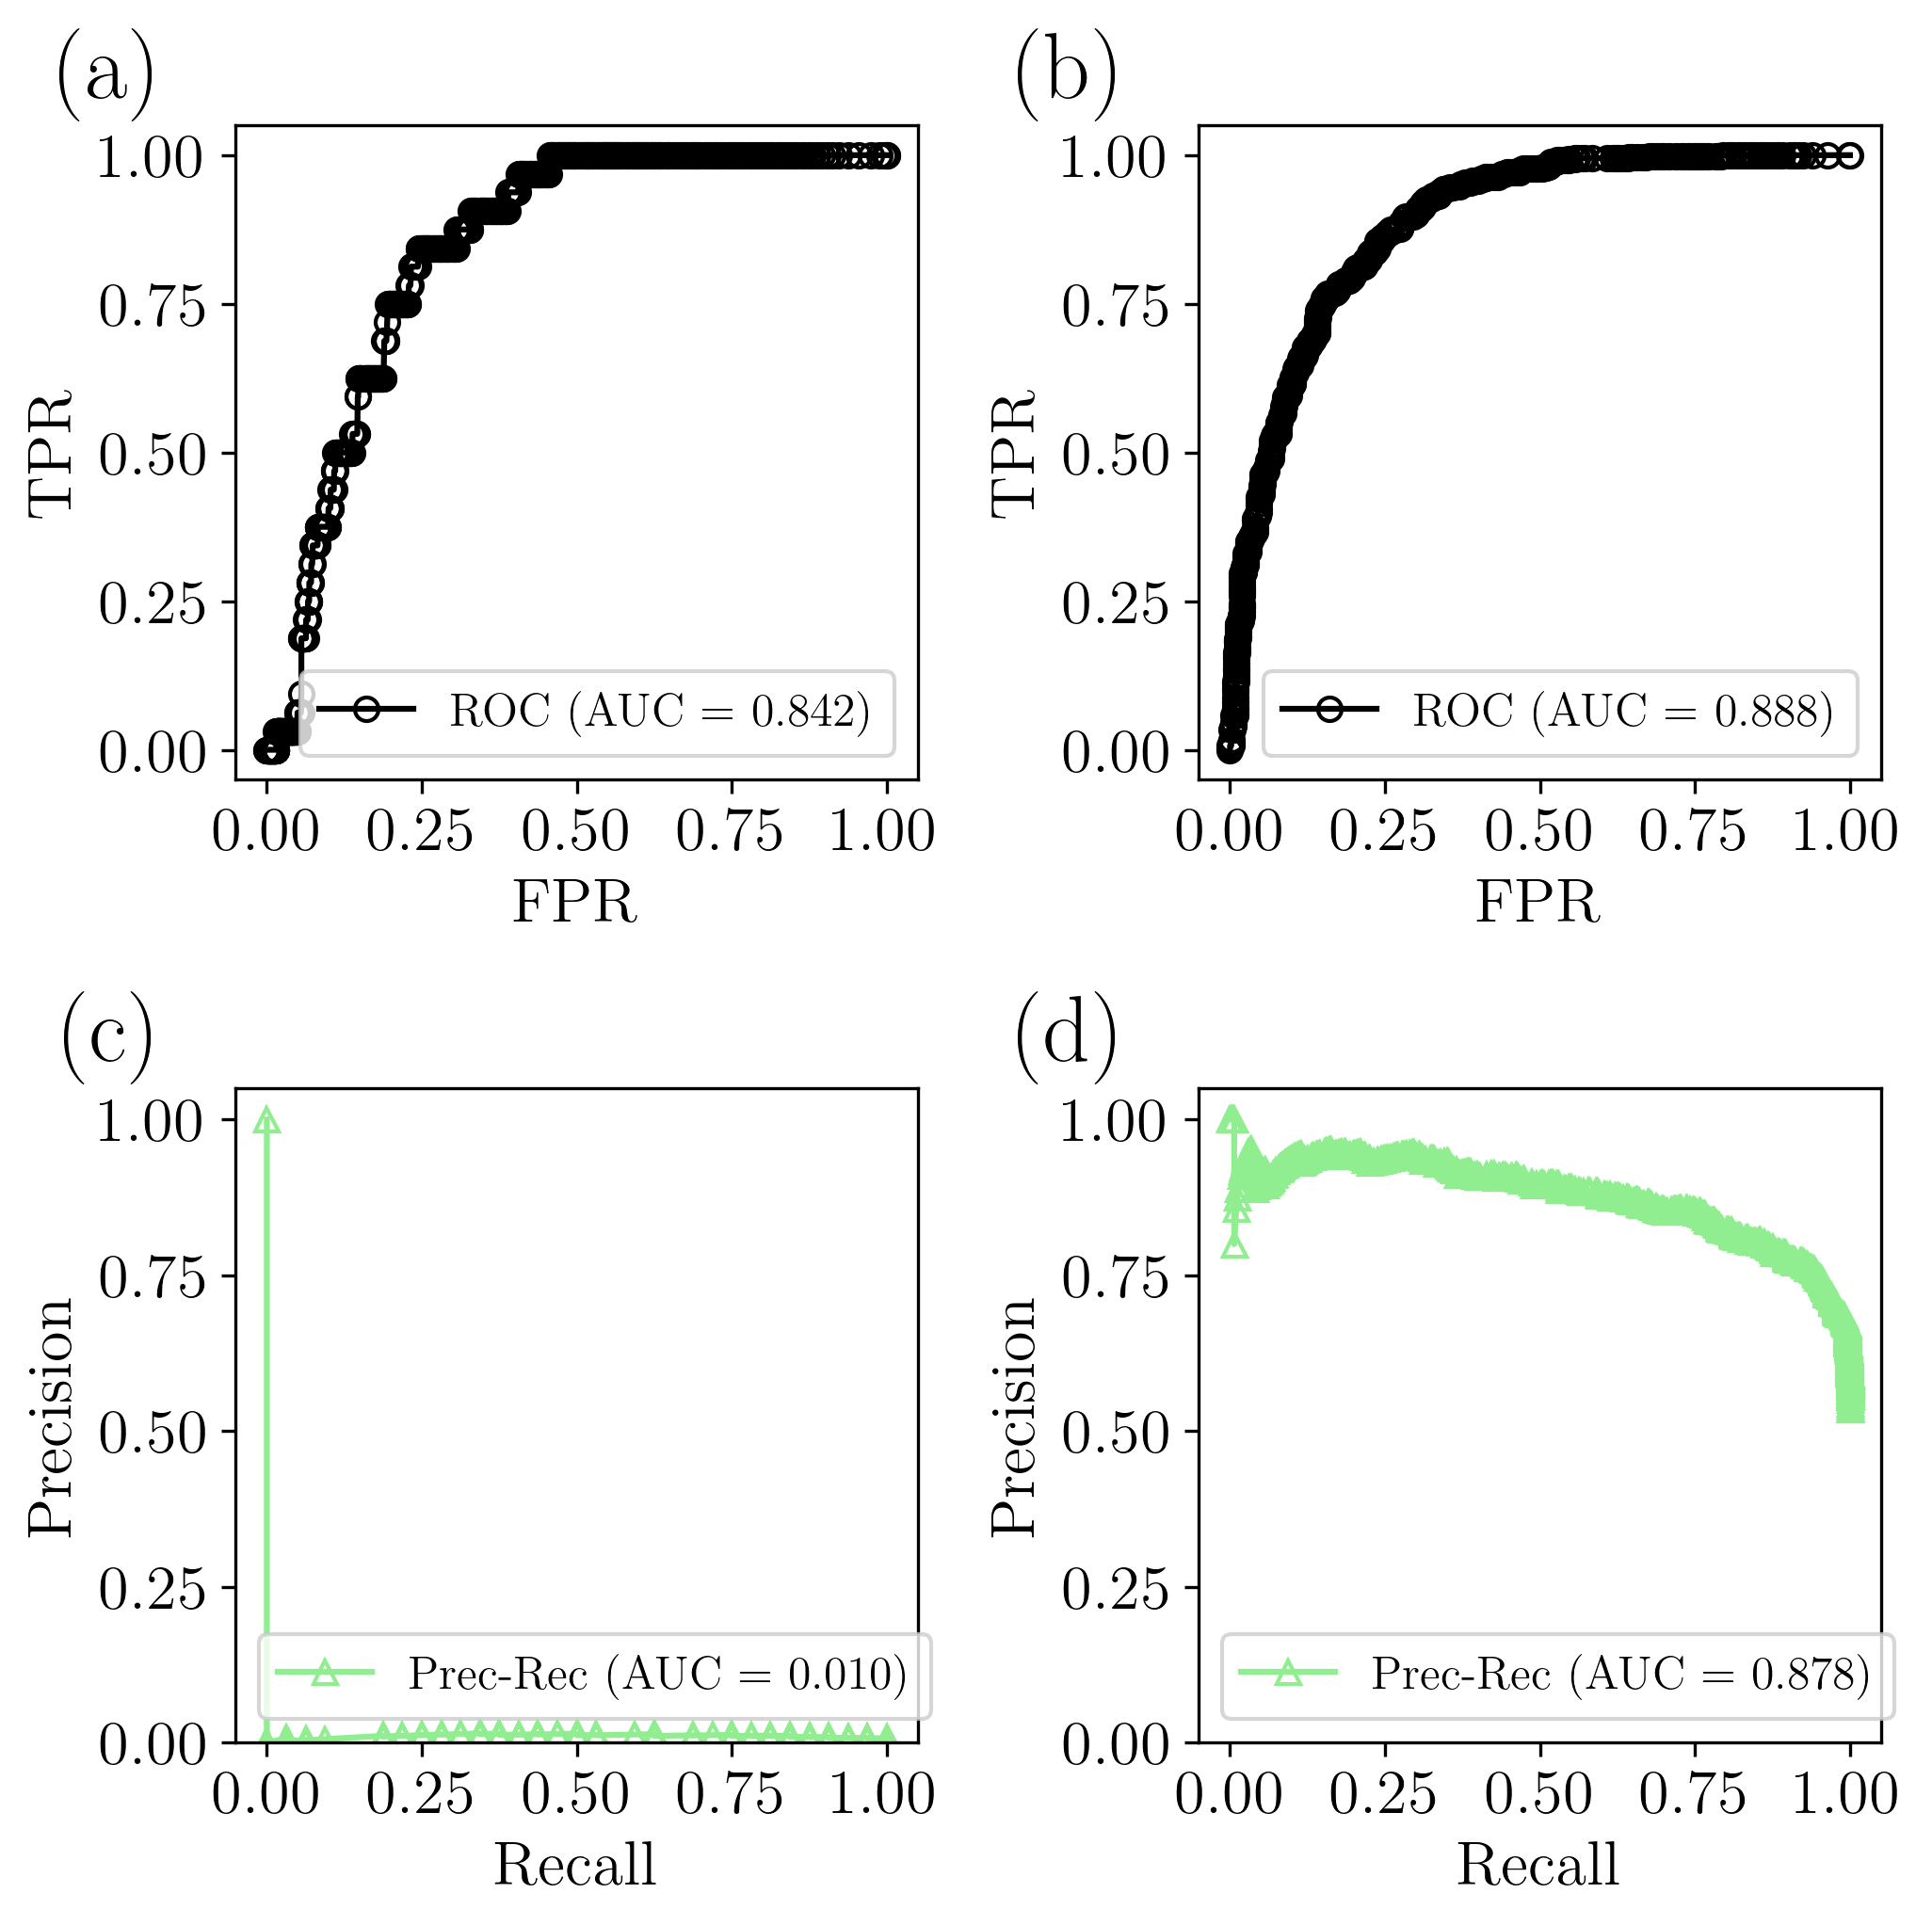

In [94]:
## Look at a few simple cases

pdb_name = "4u1c"

score_col = "Deeprank_gnn_esm"

fig,ax = plt.subplots(2, 2,figsize = (7,7), dpi = 300)

## Exhaustive Data

roc_auc, roc_x, roc_y = roc_dict_ex[pdb_name][score_col]

pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]


## ROC Curve plot
ax[0,0].plot(roc_x, roc_y, color = "black", marker = "o", markerfacecolor = "None", label = f"ROC (AUC = {roc_auc:0.3f})")

## Precision-Recall Curve
ax[1,0].plot(pr_x, pr_y, color = "lightgreen", marker = "^", markerfacecolor = "None", label = f"Prec-Rec (AUC = {pr_auc:0.3f})")


fontsize = 16
ax[0, 0].set_xlabel("FPR", fontsize = fontsize)
ax[0, 0].set_ylabel("TPR", fontsize = fontsize)

ax[1,0].set_xlabel("Recall", fontsize = fontsize)
ax[1,0].set_ylabel("Precision", fontsize = fontsize)

ax[1,0].set_ylim([0,1.05])

ax[0,0].legend()
ax[1,0].legend()

## Uniform Data

roc_auc, roc_x, roc_y = roc_dict[pdb_name][score_col]

pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]


## ROC Curve plot
ax[0,1].plot(roc_x, roc_y, color = "black", marker = "o", markerfacecolor = "None", label = f"ROC (AUC = {roc_auc:0.3f})")

## Precision-Recall Curve
ax[1,1].plot(pr_x, pr_y, color = "lightgreen", marker = "^", markerfacecolor = "None", label = f"Prec-Rec (AUC = {pr_auc:0.3f})")


fontsize = 16
ax[0,1].set_xlabel("FPR", fontsize = fontsize)
ax[0,1].set_ylabel("TPR", fontsize = fontsize)

ax[1,1].set_xlabel("Recall", fontsize = fontsize)
ax[1,1].set_ylabel("Precision", fontsize = fontsize)

ax[1,1].set_ylim([0,1.05])

ax[0,1].legend()
ax[1,1].legend()

#### FORMATTING ####

letters = [['a', 'b'], ['c', 'd']]
for i in range(2):
    for j in range(2):
        ax[i,j].tick_params(axis='both', which='major', labelsize=font_size)
        ax[i,j].text(-0.1, 1.15, f"({letters[i][j]})", transform=ax[i,j].transAxes,fontsize=font_size*1.5, fontweight='bold', va='top', ha='right')

        ## Fixing the x axis
        ax[i,j].set_xticks([0.0, 0.25, 0.50, 0.75, 1.0]) #[0.0, 0.33, 0.66, 1.0]

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"single_PR_vs_ROC_4u1c_uniform_n_exhaustive.png"))

In [32]:
## Look at the average delta AUC in the precision-recall vs ROC for each scoring function!

pdb_list = list(ss_corr_df["pdb"])

del pdb_list[pdb_list.index("5by8")]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]


delta_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
        
        roc_auc, roc_x, roc_y = roc_dict_ex[pdb_name][score_col]

        pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]
        
        delta_dict[score_col].append(pr_auc - roc_auc)
        



Avg |Delta| for ZRank2: 	 0.5764; 	 stdev:  0.2209
Avg |Delta| for ITScorePP: 	 0.5718; 	 stdev:  0.2035
Avg |Delta| for Rosetta: 	 0.5335; 	 stdev:  0.1383
Avg |Delta| for PyDock: 	 0.6035; 	 stdev:  0.2034
Avg |Delta| for VoroMQA: 	 0.6552; 	 stdev:  0.1721
Avg |Delta| for GNN-DOVE: 	 0.5714; 	 stdev:  0.2259
Avg |Delta| for Deeprank-GNN-ESM: 	 0.6366; 	 stdev:  0.1775


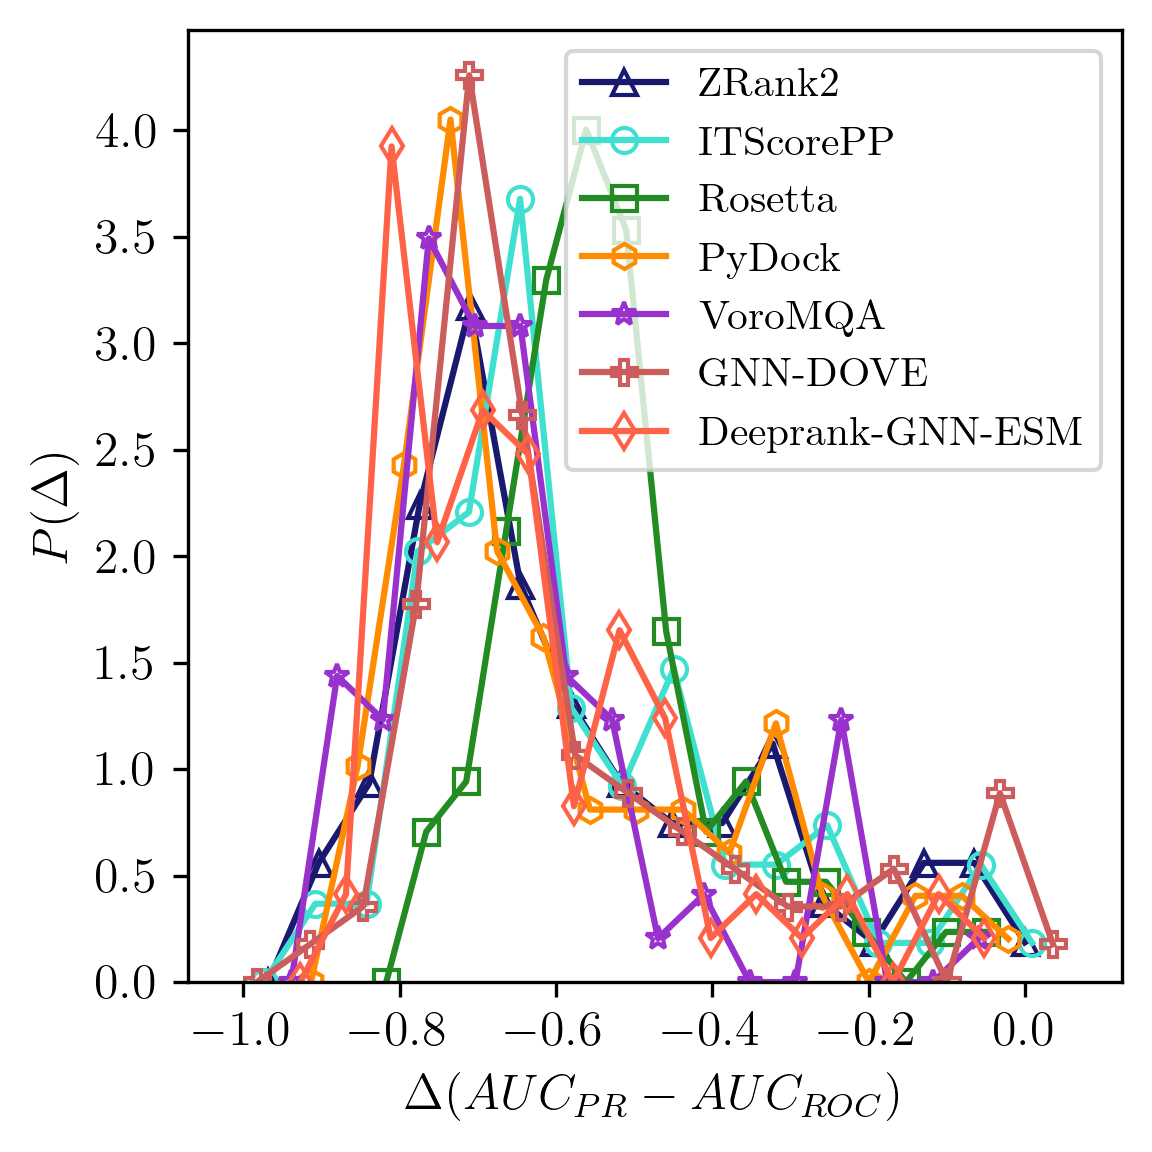

In [71]:
## Plot the deltas on the same plot

fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

nbins = 15

for i,score_col in enumerate(score_list):
    
    x = create_prob_dist_identical_bins(delta_dict[score_col], fig, ax, color = colors[i],
                                        marker = markers[i], label = actual_names[i], n_bins = nbins)
    
    print(f"Avg |Delta| for {actual_names[i]}: \t{np.mean(np.abs(delta_dict[score_col])): 0.4f}; \t stdev: {np.std(np.abs(delta_dict[score_col])): 0.4f}")
    
ax.set_xlabel("$\Delta (AUC_{PR} - AUC_{ROC})$")
ax.set_ylabel("$P(\Delta)$")

ax.legend(fontsize = 10)

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"Delta_AUCpr_AUCroc_exhaustive.png"))

## Remaking the AUC vs Rho plot for figure 2D

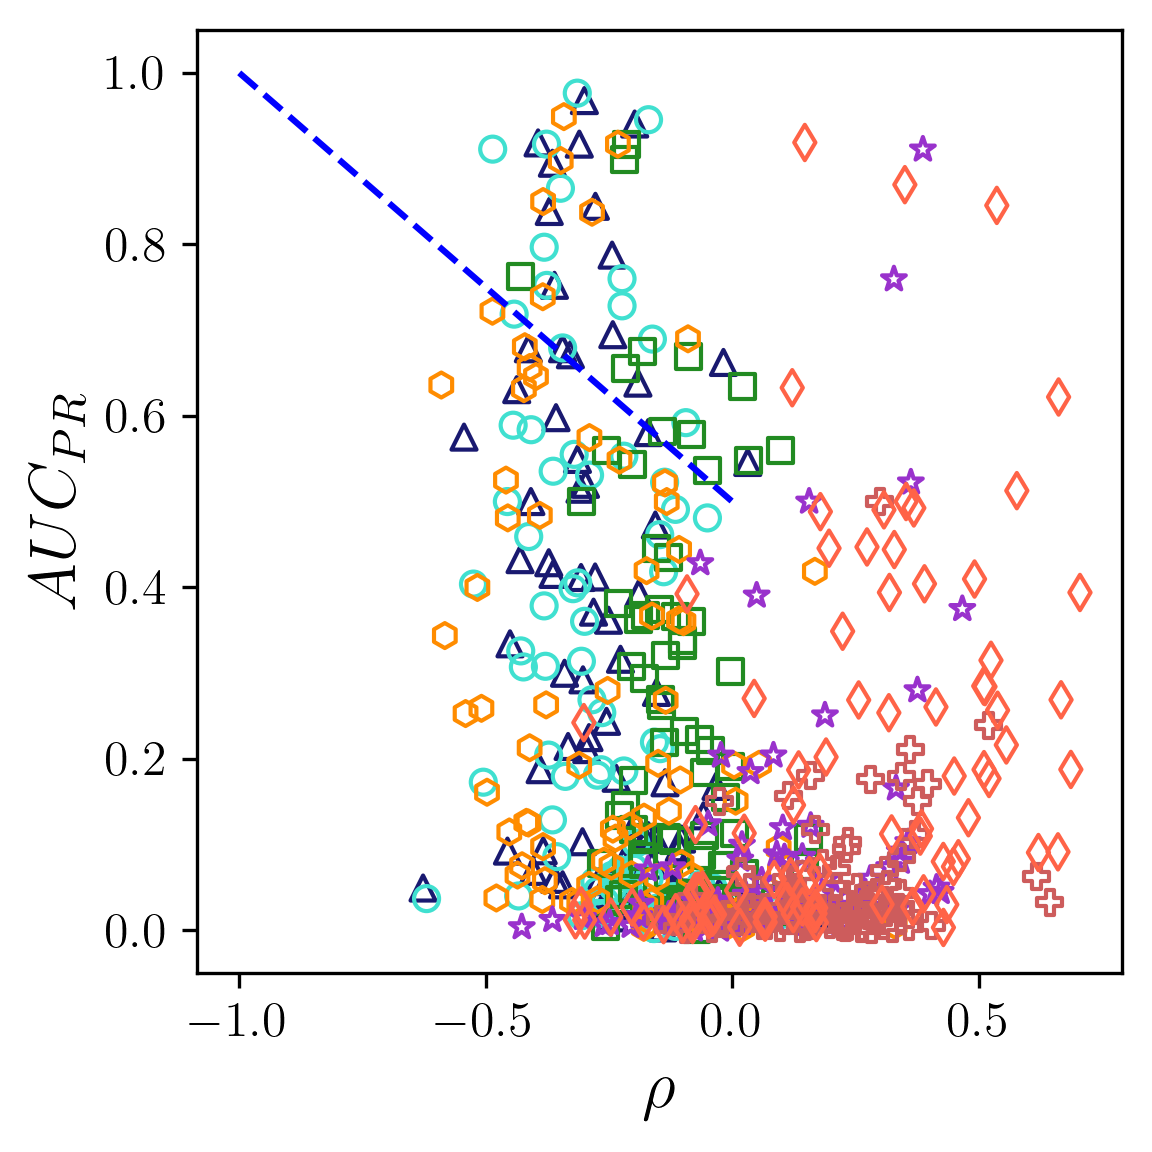

In [83]:
## Exhaustive data

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

pdb_list = list(ss_corr_df["pdb"])

fig,ax = plt.subplots(figsize = (4,4), dpi = 300)

auc_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
    
        pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]

        auc_dict[score_col].append(pr_auc)
    
    
for i, score_col in enumerate(score_list):
    
    y_data = auc_dict[score_col]
    
    rho_col_name = f"spearman_dockq_{score_col.lower()}"
    
    x_data = exhaustive_corr_df[rho_col_name]
    
    ax.scatter(x_data, y_data, label = actual_names[i], color = colors[i], marker = markers[i], facecolor = "None")
    
fontsize = 16
ax.set_xlabel(r"$\rho$", fontsize = fontsize)
ax.set_ylabel("$AUC_{PR}$", fontsize = fontsize)

## Y = -X

temp_x = np.linspace(-1, 0, 10)
temp_y = np.linspace(0.5, 1, 10)[::-1]
ax.plot(temp_x, temp_y, "b--", )

# fig.legend(loc = (0.73,0.25))

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"rho_vs_AUCpr_exhaustive.png"))

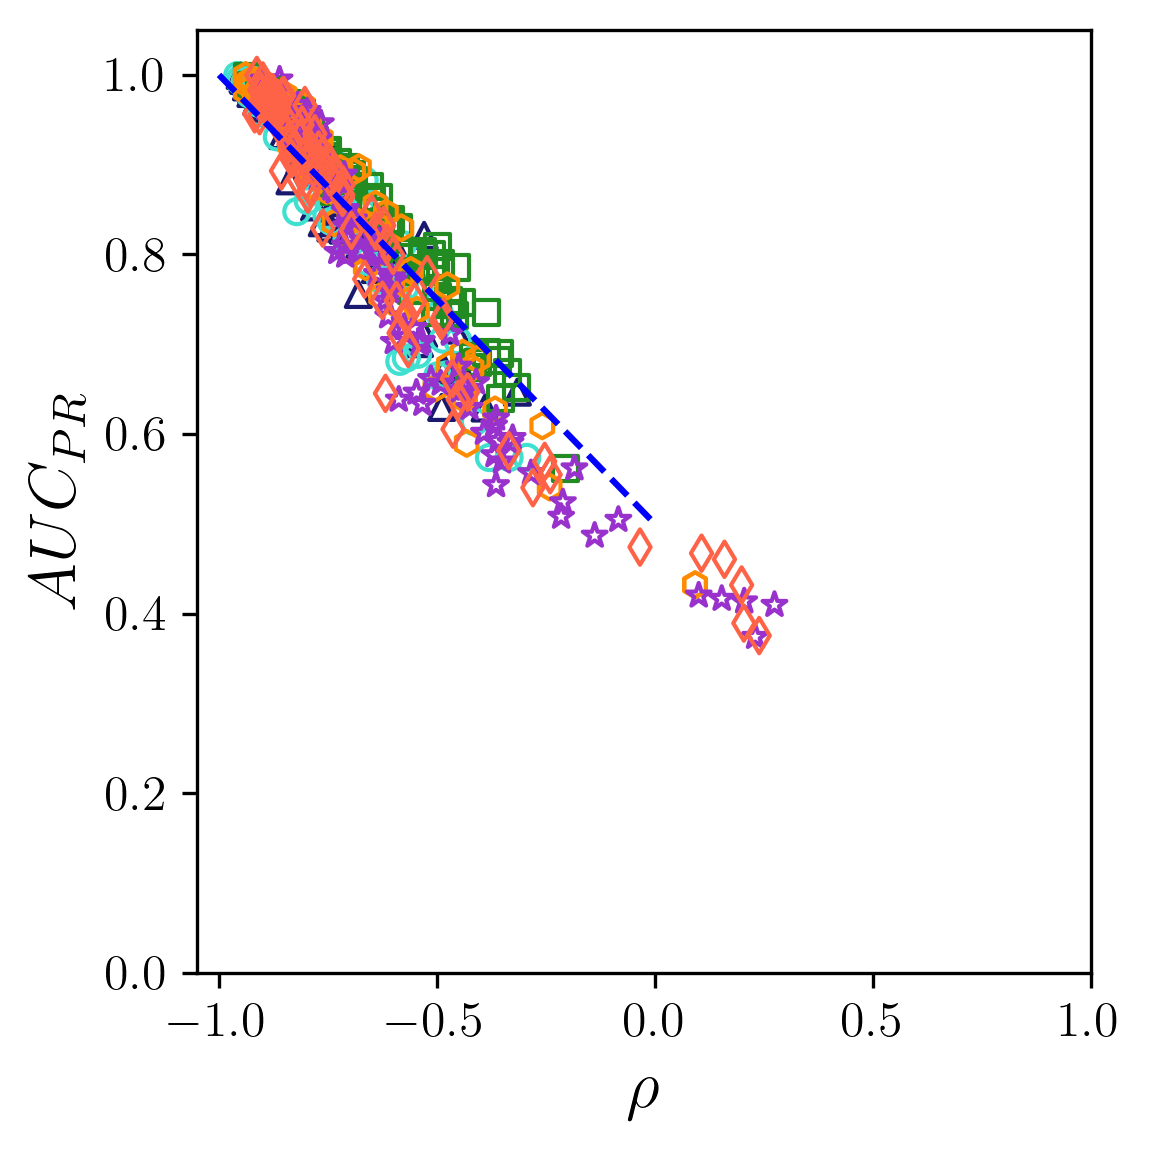

In [36]:
## Uniform Data

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

pos_factor_list = ["VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

pdb_list = list(ss_corr_df["pdb"])

fig,ax = plt.subplots(figsize = (4,4), dpi = 300)

auc_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
    
        pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]

        auc_dict[score_col].append(pr_auc)
    
    
for i, score_col in enumerate(score_list):
    
    if score_col in "Dove_5":
        continue
    
    y_data = auc_dict[score_col]
    
    rho_col_name = f"spearman_dockq_{score_col.lower()}"
    
    if score_col in pos_factor_list:
        factor = -1
    else:
        factor = 1
    
    x_data = ss_corr_df[rho_col_name] * factor
    
    
    ax.scatter(x_data, y_data, label = actual_names[i], color = colors[i], marker = markers[i], facecolor = "None")
    
fontsize = 16
ax.set_xlabel(r"$\rho$", fontsize = fontsize)
ax.set_ylabel("$AUC_{PR}$", fontsize = fontsize)

## Y = -X

temp_x = np.linspace(-1, 0, 10)
temp_y = np.linspace(0.5, 1, 10)[::-1]
ax.plot(temp_x, temp_y, "b--", )

ax.set_xlim([-1.05,1])
ax.set_ylim([0,1.05])

# fig.legend(loc = (0.73,0.25))

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"rho_vs_AUCpr_uniform.png"))

## Delta Plot

## Create precision recall list in same order 

In [39]:
key_list = ["zrank_auc", "itscorepp_auc", "rosetta_auc", "pydock_auc", "voromqa_auc", "deeprank_gnn_esm_auc"]

pr_auc_list_un = {key: [] for key in key_list}
pr_auc_list_ex = {key: [] for key in key_list}

pdb_list = list(ss_corr_df["pdb"])

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Deeprank_gnn_esm"]

for pdb_name in pdb_list:
    
    for i,score_col in enumerate(score_list):
    
        pr_auc_list_un[key_list[i]].append(prec_recall_dict[pdb_name][score_col][0])
        pr_auc_list_ex[key_list[i]].append(prec_recall_dict_ex[pdb_name][score_col][0])

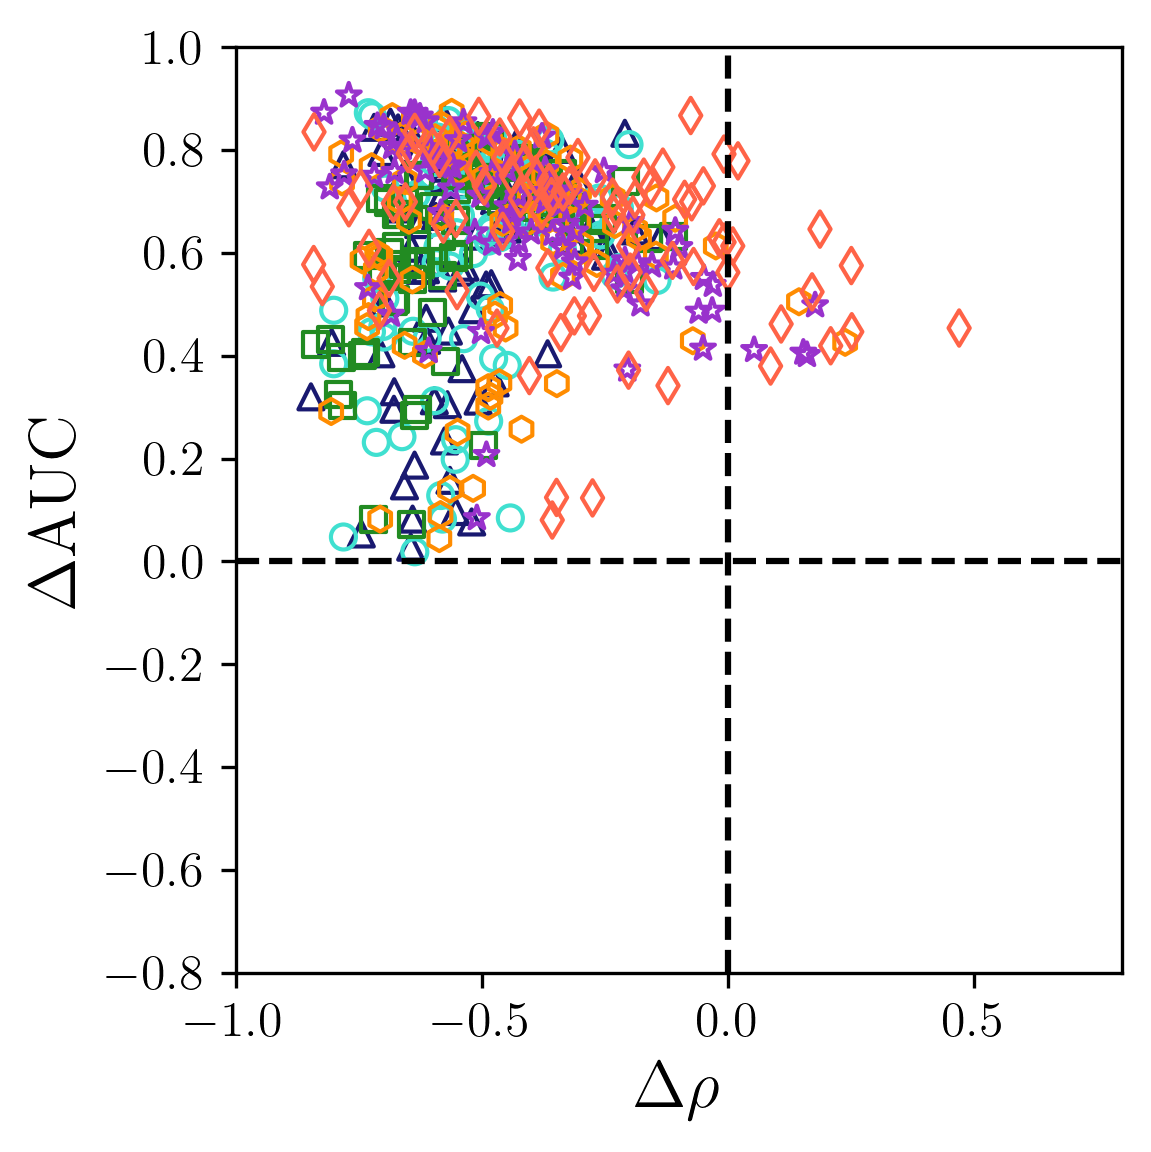

In [72]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "tomato"]

zrank_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_zrank"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_zrank"]))*-1
zrank_auc_delta = np.array(pr_auc_list_un["zrank_auc"]) - np.array(pr_auc_list_ex["zrank_auc"])

hdock_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_itscorepp"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_itscorepp"]))*-1
hdock_auc_delta = np.array(pr_auc_list_un["itscorepp_auc"]) - np.array(pr_auc_list_ex["itscorepp_auc"])

rosetta_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_rosetta"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_rosetta"]))*-1
rosetta_auc_delta = np.array(pr_auc_list_un["rosetta_auc"]) - np.array(pr_auc_list_ex["rosetta_auc"])

pydock_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_pydock"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_pydock"]))*-1
pydock_auc_delta = np.array(pr_auc_list_un["pydock_auc"]) - np.array(pr_auc_list_ex["pydock_auc"])

voromqa_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_voromqa"])) *-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_voromqa"])) *-1
voromqa_auc_delta = np.array(pr_auc_list_un["voromqa_auc"]) - np.array(pr_auc_list_ex["voromqa_auc"])

deeprank_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_deeprank_gnn_esm"])) *-1 - np.abs(np.array(relaxed_corr_df["spearman_dockq_deeprank_gnn_esm"])) *-1
deeprank_auc_delta = np.array(pr_auc_list_un["deeprank_gnn_esm_auc"]) - np.array(pr_auc_list_ex["deeprank_gnn_esm_auc"])

ax2_1 = ax.scatter(zrank_spearman_delta,
           zrank_auc_delta,
           color = colors[0], marker = "^", label = "ZRank", facecolor = "None")
ax2_2 = ax.scatter(hdock_spearman_delta,
           hdock_auc_delta,
           color = colors[1], marker = "o", label = "ITScorePP", facecolor = "None")
ax2_3 = ax.scatter(rosetta_spearman_delta,
           rosetta_auc_delta,
           color = colors[2], marker = "s", label = "Rosetta", facecolor = "None")
ax2_4 = ax.scatter(pydock_spearman_delta,
           pydock_auc_delta,
           color = colors[3], marker = "h", label = "PyDock", facecolor = "None")
ax2_5 = ax.scatter(voromqa_spearman_delta,
           voromqa_auc_delta,
           color = colors[4], marker = "*", label = "VoroMQA", facecolor = "None")
ax2_6 = ax.scatter(deeprank_spearman_delta,
           deeprank_auc_delta,
           color = colors[5], marker = "d", label = "Deeprank-GNN", facecolor = "None")

ax.set_ylabel("$\Delta$AUC", fontsize = 16)
ax.set_xlabel(r"$\Delta\rho$", fontsize = 16)

## Create vertical and horizontal dotted lines

x_vert = [0,0]
y_vert = [-0.8, 1.0]
ax.plot(x_vert, y_vert, color = "black", linestyle = "--")

x_horiz = [-1, 0.8]
y_horiz = [0,0]
ax.plot(x_horiz, y_horiz, color = "black", linestyle = "--")

ax.set_xlim([-1, 0.8])
ax.set_ylim([-0.8, 1.0])

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"Delta_rho_vs_AUCpr.png"))

## All together

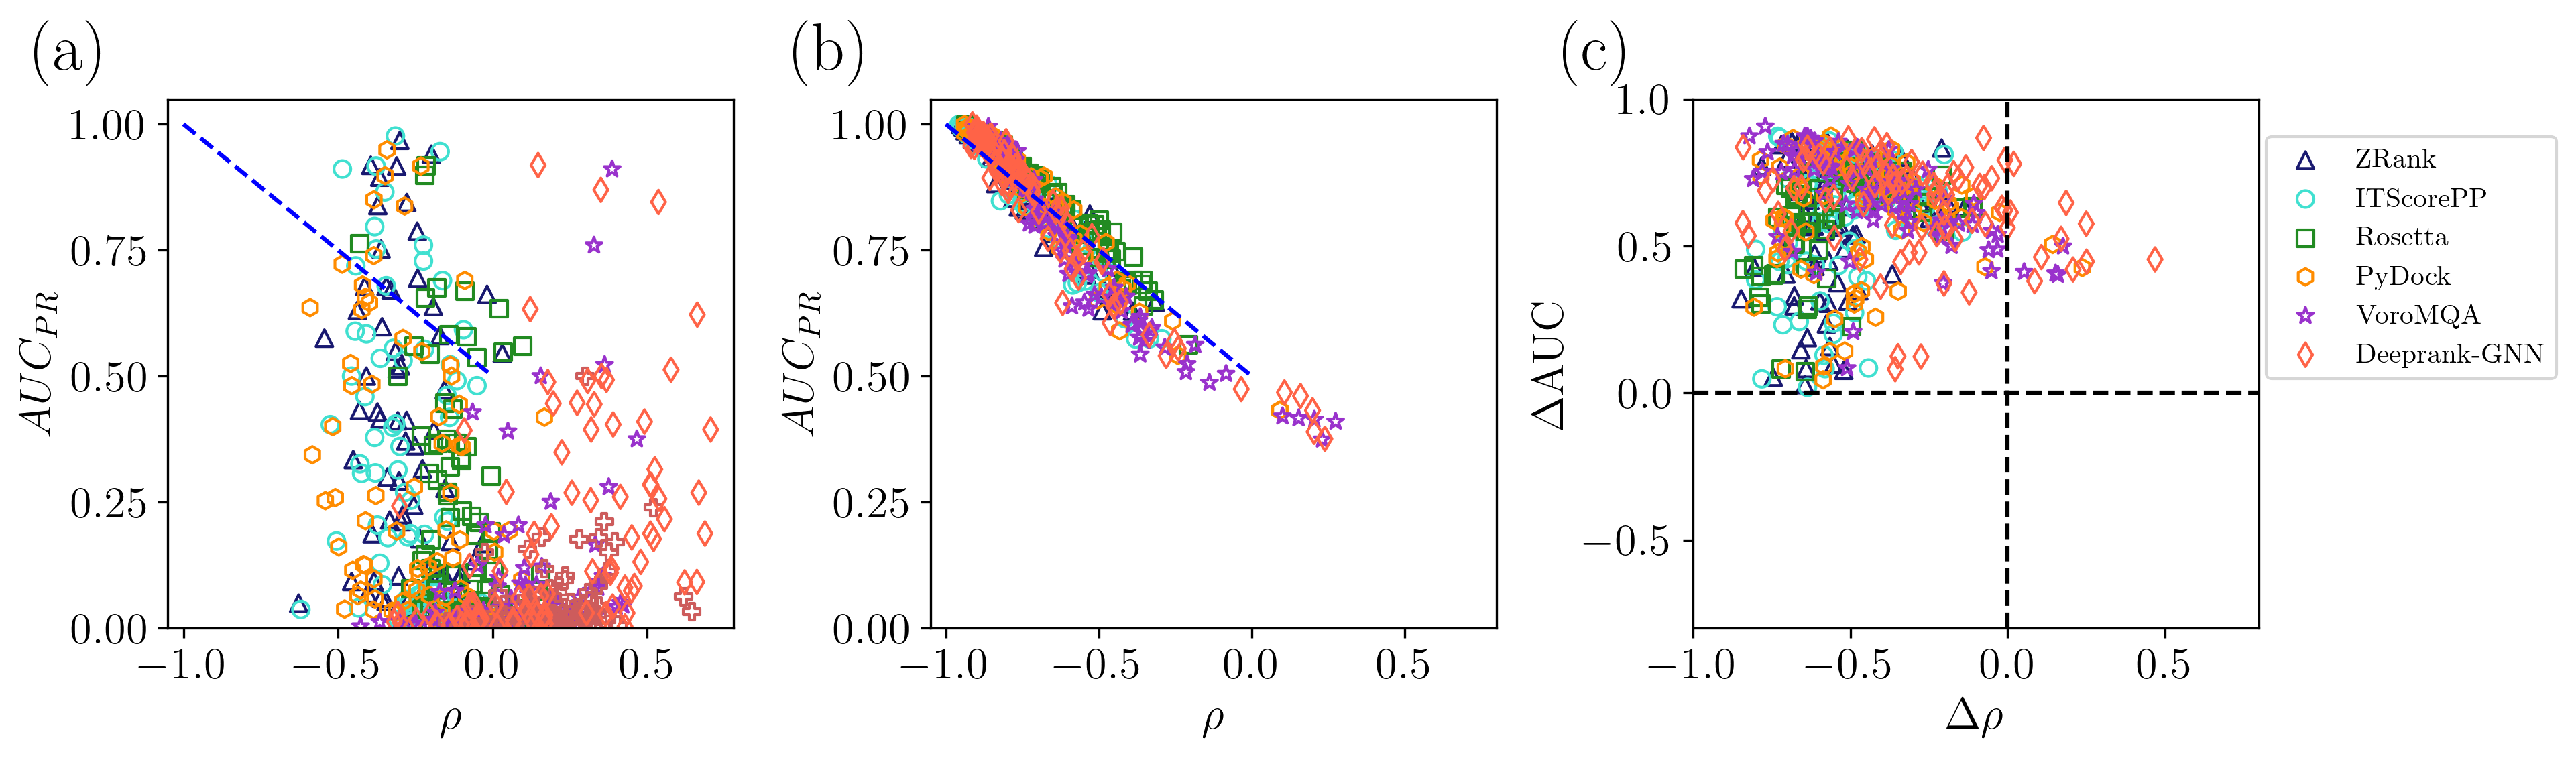

In [91]:
## Exhaustive data

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "indianred", "tomato"]

score_list = ["ZRank", "itscorepp", "Rosetta", "PyDock", "VoroMQA", "Dove_5", "Deeprank_gnn_esm"]

actual_names = ["ZRank2", "ITScorePP", "Rosetta", "PyDock", "VoroMQA", "GNN-DOVE", "Deeprank-GNN-ESM"]

markers = ["^", "o", "s", "h", "*", "P", "d"]

pdb_list = list(ss_corr_df["pdb"])

fig,ax = plt.subplots(1, 3,figsize = (13,4), dpi = 300)

#### PANEL A ####

auc_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
    
        pr_auc, pr_x, pr_y = prec_recall_dict_ex[pdb_name][score_col]

        auc_dict[score_col].append(pr_auc)
    
    
for i, score_col in enumerate(score_list):
    
    y_data = auc_dict[score_col]
    
    rho_col_name = f"spearman_dockq_{score_col.lower()}"
    
    x_data = exhaustive_corr_df[rho_col_name]
    
    ax[0].scatter(x_data, y_data, label = actual_names[i], color = colors[i], marker = markers[i], facecolor = "None")
    
fontsize = 16
ax[0].set_xlabel(r"$\rho$", fontsize = fontsize)
ax[0].set_ylabel("$AUC_{PR}$", fontsize = fontsize)

ax[0].set_xlim([-1.05,0.78])
ax[0].set_ylim([0,1.05])

## Y = -X

temp_x = np.linspace(-1, 0, 10)
temp_y = np.linspace(0.5, 1, 10)[::-1]
ax[0].plot(temp_x, temp_y, "b--", )

#### PANEL B ####

auc_dict = {score_col : [] for score_col in score_list}

for pdb_name in pdb_list:
    
    for score_col in score_list:
    
        pr_auc, pr_x, pr_y = prec_recall_dict[pdb_name][score_col]

        auc_dict[score_col].append(pr_auc)
    
    
for i, score_col in enumerate(score_list):
    
    if score_col in "Dove_5":
        continue
    
    y_data = auc_dict[score_col]
    
    rho_col_name = f"spearman_dockq_{score_col.lower()}"
    
    if score_col in pos_factor_list:
        factor = -1
    else:
        factor = 1
    
    x_data = ss_corr_df[rho_col_name] * factor
    
    
    ax[1].scatter(x_data, y_data, label = actual_names[i], color = colors[i], marker = markers[i], facecolor = "None")
    
fontsize = 16
ax[1].set_xlabel(r"$\rho$", fontsize = fontsize)
ax[1].set_ylabel("$AUC_{PR}$", fontsize = fontsize)

## Y = -X

temp_x = np.linspace(-1, 0, 10)
temp_y = np.linspace(0.5, 1, 10)[::-1]
ax[1].plot(temp_x, temp_y, "b--", )

ax[1].set_xlim([-1.05,0.8])
ax[1].set_ylim([0,1.05])

#### PANEL C ####

colors = ["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "tomato"]

zrank_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_zrank"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_zrank"]))*-1
zrank_auc_delta = np.array(pr_auc_list_un["zrank_auc"]) - np.array(pr_auc_list_ex["zrank_auc"])

hdock_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_itscorepp"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_itscorepp"]))*-1
hdock_auc_delta = np.array(pr_auc_list_un["itscorepp_auc"]) - np.array(pr_auc_list_ex["itscorepp_auc"])

rosetta_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_rosetta"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_rosetta"]))*-1
rosetta_auc_delta = np.array(pr_auc_list_un["rosetta_auc"]) - np.array(pr_auc_list_ex["rosetta_auc"])

pydock_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_pydock"]))*-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_pydock"]))*-1
pydock_auc_delta = np.array(pr_auc_list_un["pydock_auc"]) - np.array(pr_auc_list_ex["pydock_auc"])

voromqa_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_voromqa"])) *-1 - np.abs(np.array(exhaustive_corr_df["spearman_dockq_voromqa"])) *-1
voromqa_auc_delta = np.array(pr_auc_list_un["voromqa_auc"]) - np.array(pr_auc_list_ex["voromqa_auc"])

deeprank_spearman_delta = np.abs(np.array(ss_corr_df["spearman_dockq_deeprank_gnn_esm"])) *-1 - np.abs(np.array(relaxed_corr_df["spearman_dockq_deeprank_gnn_esm"])) *-1
deeprank_auc_delta = np.array(pr_auc_list_un["deeprank_gnn_esm_auc"]) - np.array(pr_auc_list_ex["deeprank_gnn_esm_auc"])

ax2_1 = ax[2].scatter(zrank_spearman_delta,
           zrank_auc_delta,
           color = colors[0], marker = "^", label = "ZRank", facecolor = "None")
ax2_2 = ax[2].scatter(hdock_spearman_delta,
           hdock_auc_delta,
           color = colors[1], marker = "o", label = "ITScorePP", facecolor = "None")
ax2_3 = ax[2].scatter(rosetta_spearman_delta,
           rosetta_auc_delta,
           color = colors[2], marker = "s", label = "Rosetta", facecolor = "None")
ax2_4 = ax[2].scatter(pydock_spearman_delta,
           pydock_auc_delta,
           color = colors[3], marker = "h", label = "PyDock", facecolor = "None")
ax2_5 = ax[2].scatter(voromqa_spearman_delta,
           voromqa_auc_delta,
           color = colors[4], marker = "*", label = "VoroMQA", facecolor = "None")
ax2_6 = ax[2].scatter(deeprank_spearman_delta,
           deeprank_auc_delta,
           color = colors[5], marker = "d", label = "Deeprank-GNN", facecolor = "None")

ax[2].set_ylabel("$\Delta$AUC", fontsize = 16)
ax[2].set_xlabel(r"$\Delta\rho$", fontsize = 16)

## Create vertical and horizontal dotted lines

x_vert = [0,0]
y_vert = [-0.8, 1.0]
ax[2].plot(x_vert, y_vert, color = "black", linestyle = "--")

x_horiz = [-1, 0.8]
y_horiz = [0,0]
ax[2].plot(x_horiz, y_horiz, color = "black", linestyle = "--")

ax[2].set_xlim([-1, 0.8])
ax[2].set_ylim([-0.8, 1.0])

###### LEGEND #######
lgnd = ax[2].legend(handles = [ax2_1, ax2_2, ax2_3, ax2_4, ax2_5, ax2_6],
        loc='center right', bbox_to_anchor=(1.55, 0.7), ncol=1, fontsize = font_size-6)
# lgnd = ax[1].legend(loc='upper right',
#           ncol=2, fontsize = font_size-8)


#### Formatting ####

letters = ['a', 'b', 'c']
for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=font_size)
    ax[i].text(-0.1, 1.15, f"({letters[i]})", transform=ax[i].transAxes,fontsize=font_size*1.5, fontweight='bold', va='top', ha='right')


fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"all_rho_vs_AUCpr_3panel.png"))

# Physical Feature Description

- Do cross-correlations of the features
- Make distributions of the features relative to other PPI datasets
- Justify why we use the features

In [134]:
ss_corr_df

Unnamed: 0   pdb  pearson_ialign_zrank  pearson_ialign_hdock  \
0            0  1acb             -0.717506             -0.572495   
1            1  1ay7             -0.804331             -0.644121   
2            2  1c3a             -0.965753             -0.961120   
3            3  1euv             -0.903749             -0.810849   
4            4  1f60             -0.934282             -0.954465   
..         ...   ...                   ...                   ...   
79          79  6zbk             -0.781797             -0.774058   
80          80  7bxh             -0.804953             -0.820440   
81          81  7joe             -0.777183             -0.849470   
82          82  7jxv             -0.619194             -0.622669   
83          83  8enf             -0.925165             -0.948351   

    pearson_ialign_rosetta  pearson_ialign_pydock  pearson_ialign_voromqa  \
0                -0.818415              -0.742908                0.774556   
1                -0.720965              -0.518193                0.524763   
2                -0.938805              -0.954437                0.768060   
3                -0.561124              -0.861152                0.159493   
4                -0.874791              -0.824968                0.788822   
..                     ...                    ...                     ...   
79               -0.835361              -0.678408                0.624669   
80               -0.814243              -0.720781                0.732772   
81               -0.664958              -0.580647                0.694228   
82               -0.477439              -0.504229                0.413785   
83               -0.874378              -0.797852                0.750706   

    pearson_ialign_voromqa_js  pearson_ialign_dove_5  \
0                    0.848402               0.564269   
1                    0.730545               0.788741   
2                    0.969857              -0.877749   
3                    0.793307               0.497068   
4                    0.839942              -0.579722   
..                        ...                    ...   
79                   0.850289               0.749478   
80                   0.929094              -0.467024   
81                   0.888198               0.623389   
82                   0.575321               0.558159   
83                   0.925741              -0.763693   

    pearson_ialign_intertwined  ...  contact_43_auc  contact_44_auc  \
0                    -0.550571  ...        0.762547        0.764547   
1                    -0.439244  ...        0.856978        0.855582   
2                    -0.791142  ...        0.984526        0.984476   
3                    -0.812000  ...        0.964044        0.962955   
4                    -0.814475  ...        0.961521        0.961780   
..                         ...  ...             ...             ...   
79                   -0.432070  ...        0.870750        0.869815   
80                   -0.319278  ...        0.934254        0.934713   
81                   -0.771127  ...        0.867603        0.869121   
82                    0.088424  ...        0.685357        0.688350   
83                   -0.656972  ...        0.965651        0.966413   

    contact_45_auc  interface_rsa_auc  itscorepp_auc  flatness_p3  resolution  \
0         0.764325           0.644104       0.772073     0.975254        2.00   
1         0.855477           0.866396       0.852197     0.986755        1.70   
2         0.985112           0.987780       0.991357     0.928116        2.50   
3         0.962283           0.955443       0.966066     0.977500        1.60   
4         0.961856           0.964506       0.971226     0.968571        1.67   
..             ...                ...            ...          ...         ...   
79        0.870923           0.903562       0.925137     0.988550        1.49   
80        0.933303           0.882509       0.937586     0.977949        2.70   
81     

Pearson Corrlation between the two variables: (-0.7615935056499921, 4.0784282164415304e-17)
Spearman Corrlation between the two variables: SpearmanrResult(correlation=-0.8356181026627518, pvalue=4.837082324068372e-23)


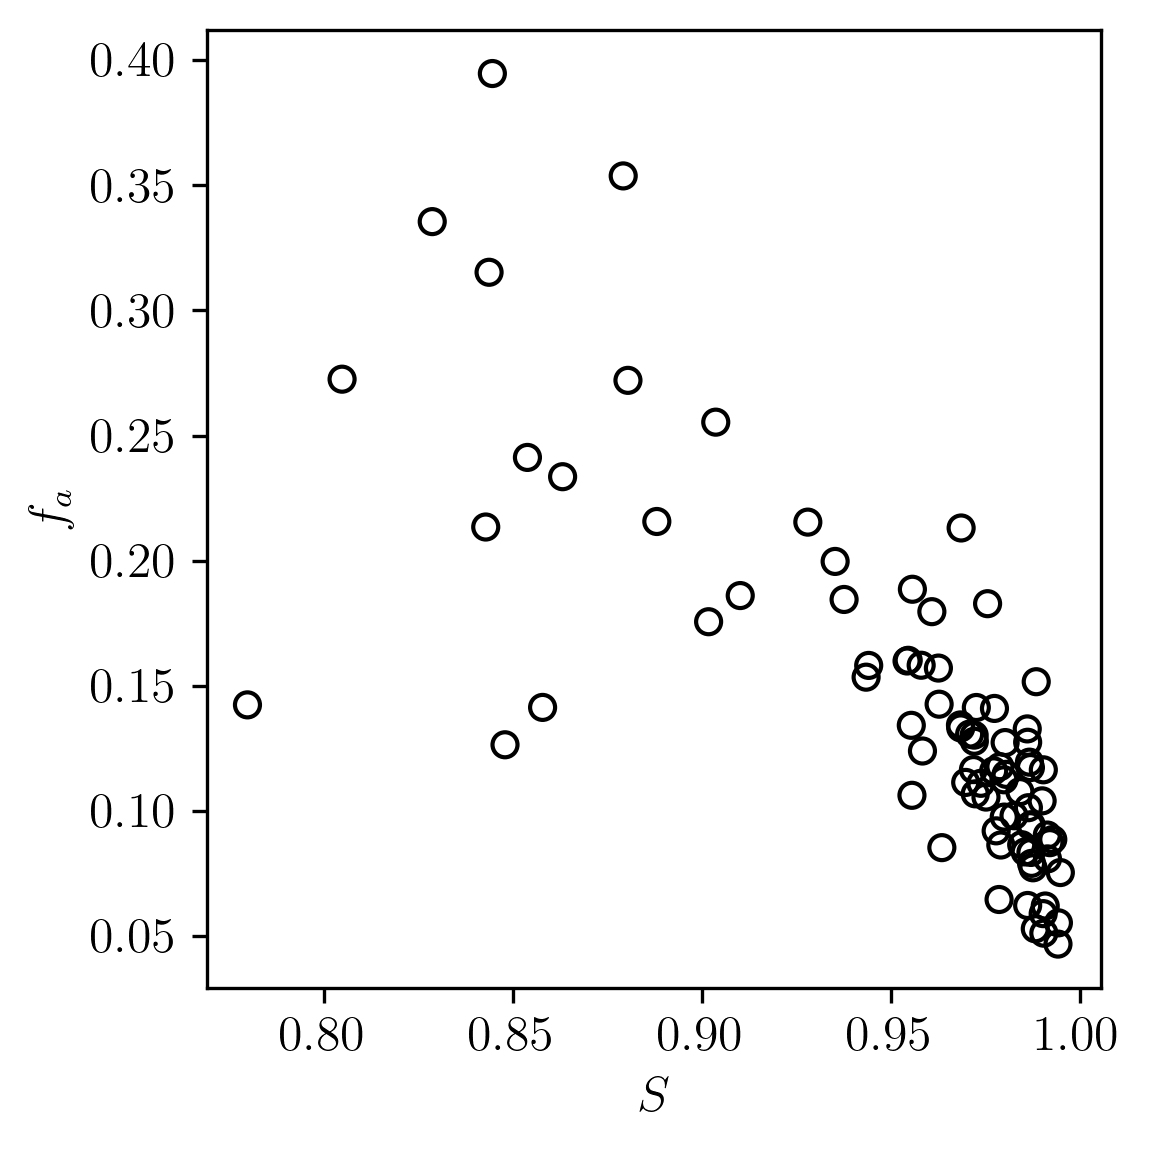

In [73]:
## Just look at it all for the targets

fig, ax = plt.subplots(1,1, figsize = (4, 4), dpi = 300)


S = ss_corr_df["flatness_p3"]
fa = ss_corr_df["relative_interface_sasa"]

ax.scatter(S, fa, color = "black", marker = "o", facecolor = "None")

ax.set_xlabel("$S$")
ax.set_ylabel("$f_a$")

print(f"Pearson Corrlation between the two variables: {pearsonr(S, fa)}")
print(f"Spearman Corrlation between the two variables: {spearmanr(S, fa)}")

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"fa_vs_S_correlation.png"))

Pearson Corrlation between the two variables: (-0.7615935056499921, 4.0784282164415304e-17)
Spearman Corrlation between the two variables: SpearmanrResult(correlation=-0.8356181026627518, pvalue=4.837082324068372e-23)


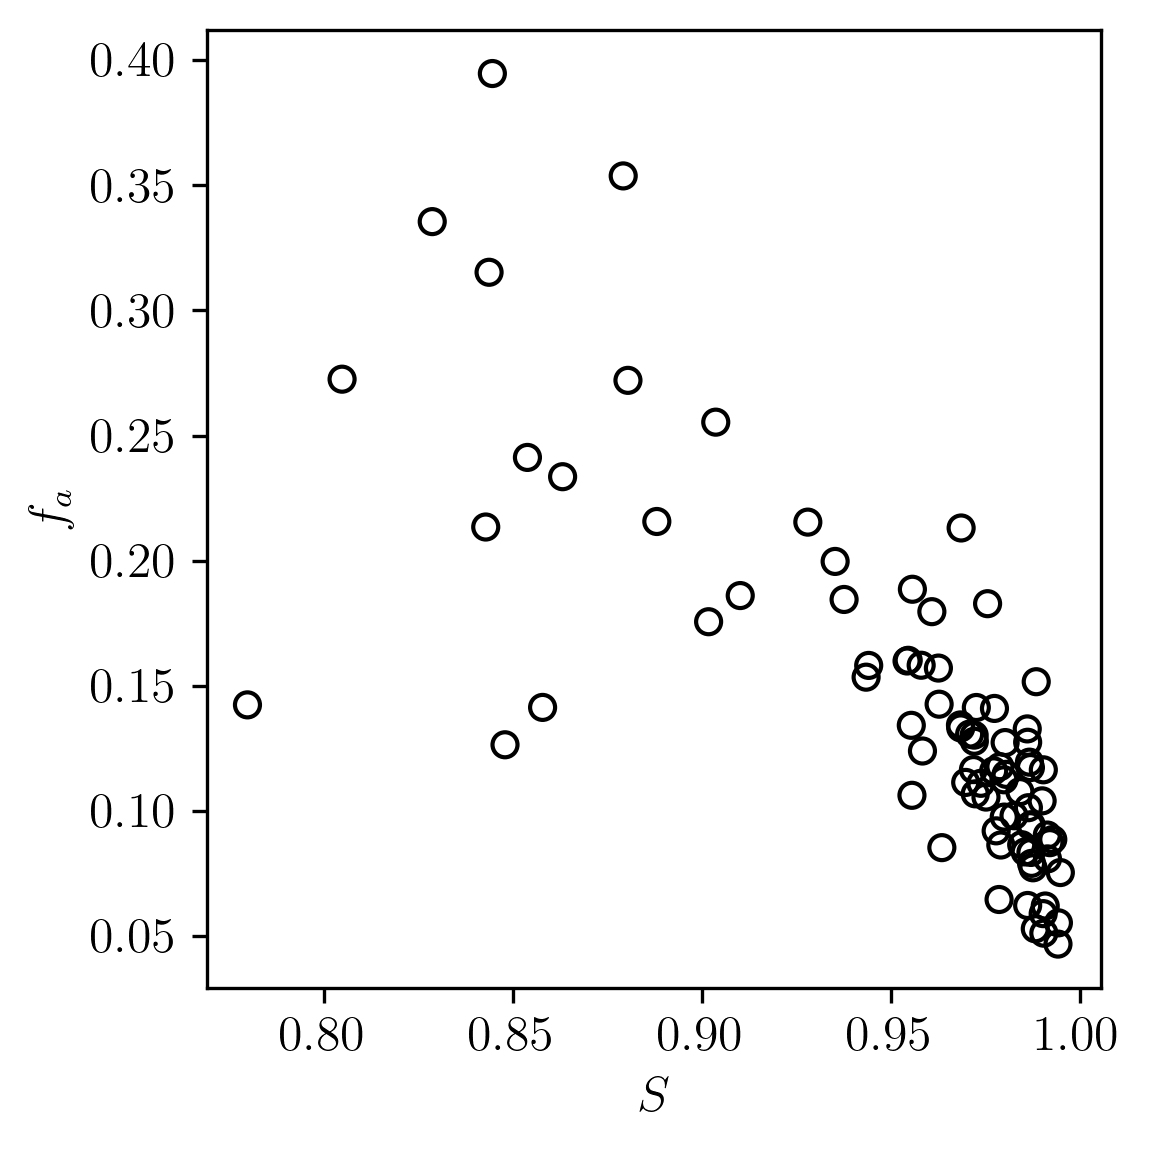

In [74]:
## Just look at it all for the targets

fig, ax = plt.subplots(1,1, figsize = (4, 4), dpi = 300)


S = ss_corr_df["flatness_p3"]
fa = ss_corr_df["relative_interface_sasa"]

ax.scatter(S, fa, color = "black", marker = "o", facecolor = "None")

ax.set_xlabel("$S$")
ax.set_ylabel("$f_a$")

fig.tight_layout()

print(f"Pearson Corrlation between the two variables: {pearsonr(S, fa)}")
print(f"Spearman Corrlation between the two variables: {spearmanr(S, fa)}")

## Load in the Zdock Benchmark data

In [51]:
os.chdir("/Users/jakesumner/OneDrive/Desktop/Yale CBB/OHern Lab/Rebuttal_data")

bm_55_contacts = pd.read_csv("bm_55_contacts.txt")
bm_55_separability = pd.read_csv("bm_55_intertwined.csv")
bm_55_sasa = pd.read_csv("bm_55_sasa.csv")

In [46]:
bm_55_separability

Unnamed: 0           decoy  flatness_p3
0            0  1ACB_complex_H     0.975254
1            1  1ATN_complex_H     0.989428
2            2  1AVX_complex_H     0.979170
3            3  1AY7_complex_H     0.986755
4            4  1BKD_complex_H     0.975384
..         ...             ...          ...
62          62  2UUY_complex_H     0.976913
63          63  2VDB_complex_H     0.988482
64          64  2Z0E_complex_H     0.975709
65          65  3SGQ_complex_H     0.972379
66          66  7CEI_complex_H     0.983328

[67 rows x 3 columns]

In [47]:
bm_55_sasa

Unnamed: 0           decoy          sasa
0             0        1ACB_E_H  10531.783704
1             1        1ACB_I_H   4248.852080
2             2  1ACB_complex_H  13223.099842
3             3        1ATN_A_H  16903.888623
4             4        1ATN_D_H  10404.378475
..          ...             ...           ...
196         196        3SGQ_I_H   3451.324182
197         197  3SGQ_complex_H   9651.997252
198         198        7CEI_A_H   5360.294775
199         199        7CEI_B_H   7794.910839
200         200  7CEI_complex_H  11746.743095

[201 rows x 3 columns]

In [48]:
## Get the fractional surface area for the data

bm_pdb_list = [s[:4] for s in bm_55_separability["decoy"]]

In [49]:
bm_fa = {
    "target": [],
    "fa" : []
}

for i in range(0,len(bm_55_sasa), 3):

    temp_df = bm_55_sasa.iloc[i:i+3]
    
    pdb_name = bm_pdb_list[i//3]
    
    base_name = f"{pdb_name}_complex_H"
    
    dimer_sasa = 0
    complex_sasa = 1
    
    for j in range(3):
        
        curr_row = temp_df.iloc[j]
        
        if len(curr_row["decoy"]) == 8:
            dimer_sasa += curr_row["sasa"]
            
        elif curr_row["decoy"] == base_name:
            complex_sasa = curr_row["sasa"]
    
    bm_fa["target"].append(pdb_name)
#     print(dimer_sasa, complex_sasa)
    bm_fa["fa"].append(np.abs(complex_sasa - dimer_sasa)/dimer_sasa)
    
bm_fa_df = pd.DataFrame(bm_fa)

In [50]:
bm_fa_df

target        fa
0    1ACB  0.105377
1    1ATN  0.065536
2    1AVX  0.088812
3    1AY7  0.119436
4    1BKD  0.098915
..    ...       ...
62   2UUY  0.098606
63   2VDB  0.055577
64   2Z0E  0.118557
65   3SGQ  0.112847
66   7CEI  0.107065

[67 rows x 2 columns]

## Comparing the physical features - Fa

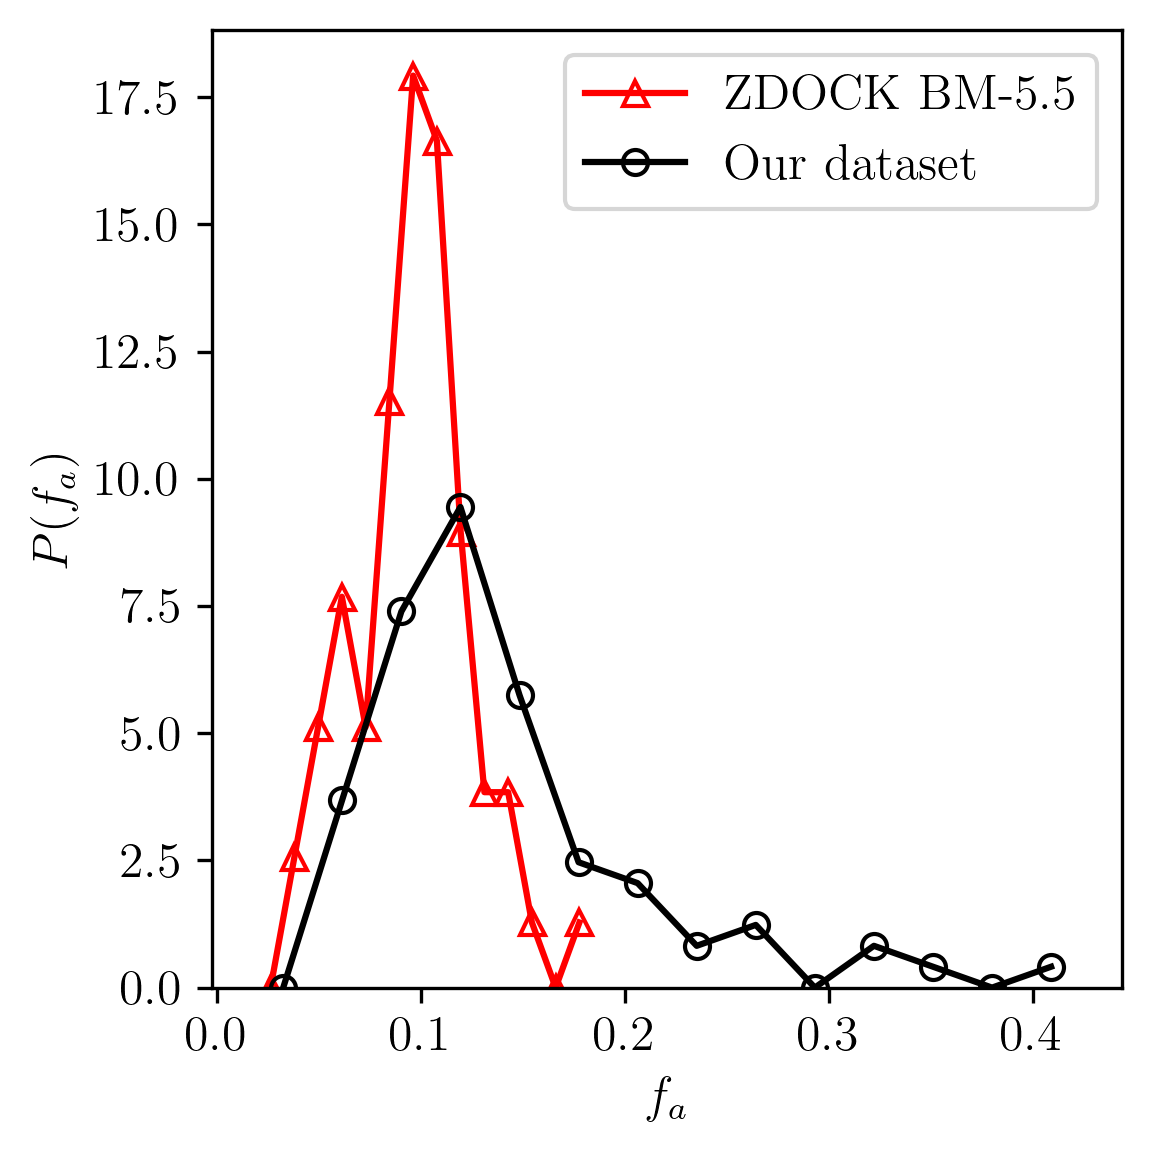

In [68]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

nbins = 13
x = create_prob_dist_identical_bins(bm_fa_df["fa"], fig, ax, n_bins = nbins, color = "red", marker = "^", label = "ZDOCK BM-5.5")
x = create_prob_dist_identical_bins(ss_corr_df["relative_interface_sasa"], fig, ax, n_bins = nbins, color = "black", marker = "o", label = "Our dataset")

ax.set_xlabel("$f_a$")
ax.set_ylabel("$P(f_a)$")

ax.legend()

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"fa_prob_dist_vs_zdockbm.png"))

## Interface separability

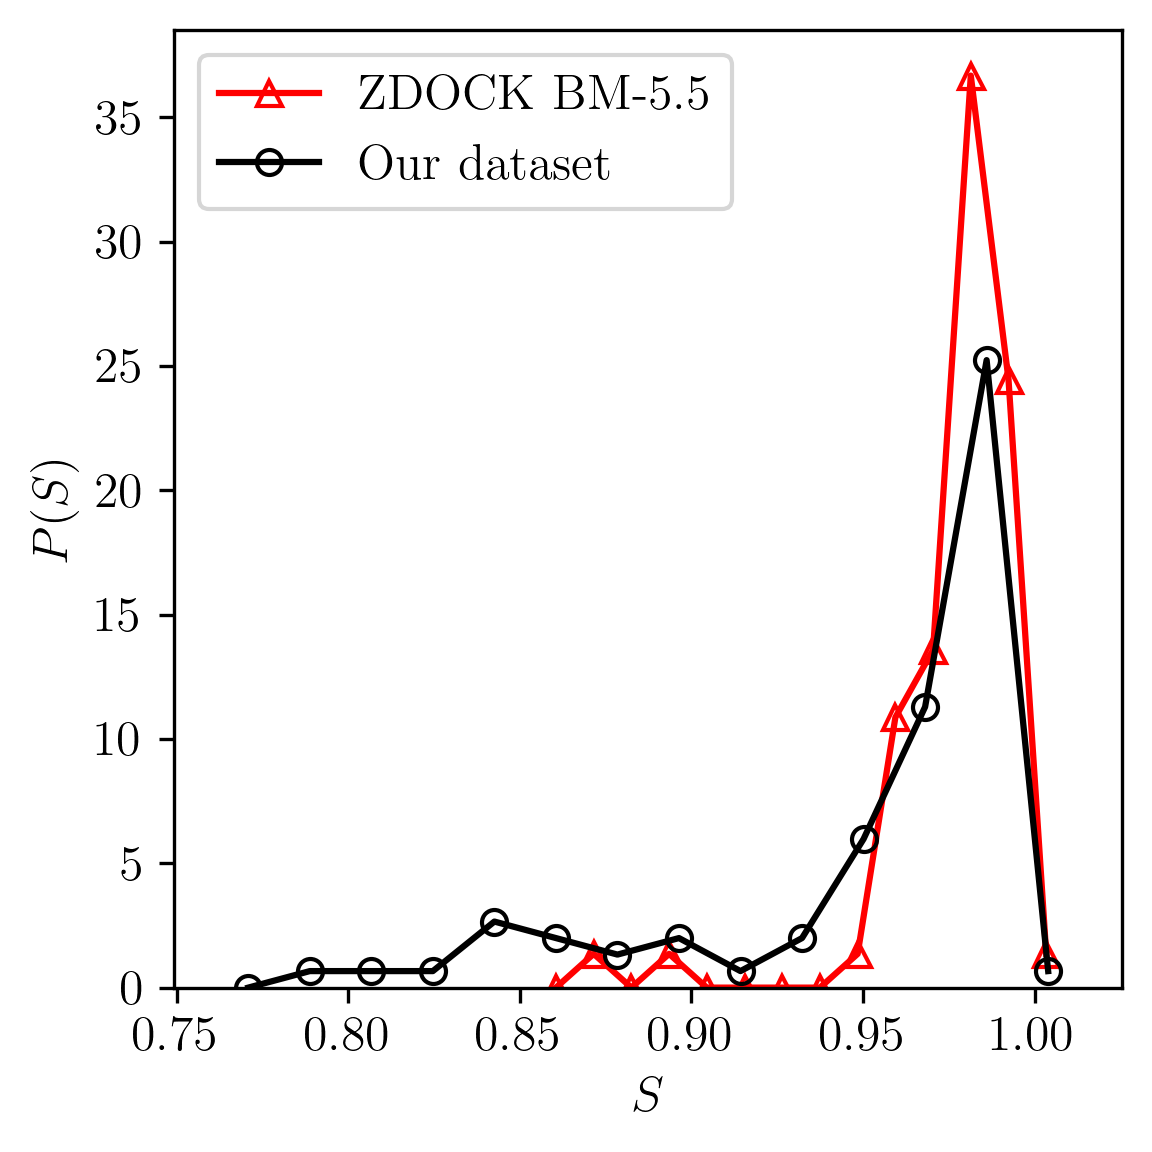

In [67]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 300)

nbins = 13
x = create_prob_dist_identical_bins(bm_55_separability["flatness_p3"], fig, ax, n_bins = nbins, color = "red", marker = "^", label = "ZDOCK BM-5.5")
x = create_prob_dist_identical_bins(ss_corr_df["flatness_p3"], fig, ax, n_bins = nbins, color = "black", marker = "o", label = "Our dataset")

ax.set_xlabel("$S$")
ax.set_ylabel("$P(S)$")

ax.legend()

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"s_prob_dist_vs_zdockbm.png"))

# Contacts comparison

In [55]:
## Import more stuff

from create_protein_graph_structure import get_protein_information, get_ha_coords, get_ca_coords, get_aa_list, create_adjacency_matrix, feature_interface_one_hot

In [57]:
## Run some of the code to generate the protein information - Original 84

orig_84_dir = "/Users/jakesumner/OneDrive/Desktop/Yale CBB/OHern Lab/Rebuttal_data/original_84_complex"

os.chdir(orig_84_dir)

orig_84_pdbs = glob("*.pdb")

orig_84_dict = {}

for pdb_name in orig_84_pdbs:

    protein_df = get_protein_information(pdb_name, orig_84_dir)

    temp_ha_coords = get_ha_coords(protein_df)

    temp_ca_coords = get_ca_coords(protein_df)

    temp_aa_list = get_aa_list(protein_df)
    
    temp_adj_mat = create_adjacency_matrix(temp_ha_coords)
    
    temp_interface_num = 0
    
    total_len = np.max(protein_df["aa_id"]) + 1
    
    chain_1_len = len(temp_ha_coords[0])
    
    for node_ind in range(total_len):
        
        temp_interface_num += feature_interface_one_hot(temp_adj_mat, node_ind, chain_1_len)
    
    orig_84_dict[pdb_name[:4]] = [temp_interface_num, protein_df]


KeyboardInterrupt: 

In [ ]:
## Run some of the code to generate the protein information - New data

bm_55_dir = "/Users/jakesumner/OneDrive/Desktop/Yale CBB/OHern Lab/Rebuttal_data/dimer_bm_55_complex"

os.chdir(bm_55_dir)

bm_55_pdbs = glob.glob("*.pdb")

bm_55_dict = {}

for pdb_name in bm_55_pdbs:

    protein_df = get_protein_information(pdb_name, bm_55_dir)

    temp_ha_coords = get_ha_coords(protein_df)

    temp_ca_coords = get_ca_coords(protein_df)

    temp_aa_list = get_aa_list(protein_df)
    
    temp_adj_mat = create_adjacency_matrix(temp_ha_coords)
    
    temp_interface_num = 0
    
    total_len = np.max(protein_df["aa_id"]) + 1
    
    chain_1_len = len(temp_ha_coords[0])
    
    for node_ind in range(total_len):
        
        temp_interface_num += feature_interface_one_hot(temp_adj_mat, node_ind, chain_1_len)
    
    bm_55_dict[pdb_name[:4]] = [temp_interface_num, protein_df]


In [57]:
bm_55_dict["1ACB"]

[37.0,
       chain_id  aa_id aa_name atom_name  atom_radius  x_coord    y_coord  \
 0            1      0       C         N          1.3    2.323 -16.405001   
 1            1      0       C        CA          1.5    3.017 -15.136000   
 2            1      0       C         C          1.3    4.134 -15.068000   
 3            1      0       C         O          1.4    4.173 -15.810000   
 4            1      0       C        CB          1.5    2.052 -13.969000   
 ...        ...    ...     ...       ...          ...      ...        ...   
 4521         2    303       G         O          1.4   12.671  16.511000   
 4522         2    303       G       OXT          1.4   12.385  14.435000   
 4523         2    303       G         H          1.0   13.982  17.101000   
 4524         2    303       G       HA2          1.1   14.324  14.639000   
 4525         2    303       G       HA3          1.1   15.088  15.149000   
 
         z_coord  ca_bool  ha_bool  hyd_bool  
 0     18.812000    

In [58]:
orig_84_dict["1acb"]

[37.0,
       chain_id  aa_id aa_name atom_name  atom_radius  x_coord    y_coord  \
 0            1      0       C         N          1.3    2.323 -16.405001   
 1            1      0       C        CA          1.5    3.017 -15.136000   
 2            1      0       C         C          1.3    4.134 -15.068000   
 3            1      0       C         O          1.4    4.173 -15.810000   
 4            1      0       C        CB          1.5    2.052 -13.969000   
 ...        ...    ...     ...       ...          ...      ...        ...   
 4521         2    303       G         O          1.4   12.671  16.511000   
 4522         2    303       G       OXT          1.4   12.385  14.435000   
 4523         2    303       G         H          1.0   13.982  17.101000   
 4524         2    303       G       HA2          1.1   14.324  14.639000   
 4525         2    303       G       HA3          1.1   15.088  15.149000   
 
         z_coord  ca_bool  ha_bool  hyd_bool  
 0     18.812000    

In [58]:
## Getting the number of contacts divided by the total number of interface atoms

base_dir = "/Users/jakesumner/OneDrive/Desktop/Yale CBB/OHern Lab/Rebuttal_data"

os.chdir(base_dir)

orig_84_contact_df = pd.read_csv("targets_84_contacts.csv")

bm_55_contact_df = pd.read_csv("bm_55_contacts.txt")

In [60]:
orig_84_contact_df

Unnamed: 0           decoy  ca_8.0  ca_8.1  ca_8.2  ca_8.3  ca_8.4  \
0            0  1acb_complex_H      43      48      49      54      57   
1            1  1ay7_complex_H      22      27      28      29      30   
2            2  1bpl_complex_H     149     156     165     174     184   
3            3  1brb_complex_H      50      52      55      57      59   
4            4  1c3a_complex_H      93      96     100     108     116   
..         ...             ...     ...     ...     ...     ...     ...   
94          94  6zbk_complex_H      28      33      35      37      42   
95          95  7bxh_complex_H      40      42      45      48      51   
96          96  7joe_complex_H      46      47      49      52      56   
97          97  7jxv_complex_H      30      32      34      37      38   
98          98  8enf_complex_H     108     112     117     123     129   

    ca_8.5  ca_8.6  ca_8.7  ...  ha_u_4.1  ha_u_4.2  ha_u_4.3  ha_u_4.4  \
0       61      66      72  ...        43        46        48        50   
1       34      35      37  ...        29        31        32        32   
2      191     203     212  ...       151       161       170       180   
3       63      66      69  ...        40        44        45        48   
4      126     132     140  ...        93        98       101       105   
..     ...     ...     ...  ...       ...       ...       ...       ...   
94      44      47      52  ...        42        45        48        51   
95      58      64      67  ...        47        55        56        62   
96      62      69      73  ...        53        55        60        63   
97      40      40      41  ...        27        29        32        32   
98     132     135     140  ...        74        78        85        90   

    ha_u_4.5  ha_u_4.6  ha_u_4.7  ha_u_4.8  ha_u_4.9  ha_u_5.0  
0         52        54        55        59        63        63  
1         34        36        36        39        39        40  
2        189       198       205       207       213       217  
3         48        52        54        54        56        59  
4        107       109       111       118       125       127  
..       ...       ...       ...       ...       ...       ...  
94        53        55        56        57        58        59  
95        64        66        72        76        81        82  
96        66        67        68        69        71        75  
97        34        34        36        38        39        40  
98        95        98       100       103       111       118  

[99 rows x 45 columns]

In [61]:
bm_55_contact_df

Unnamed: 0           decoy  ca_8.0  ca_8.1  ca_8.2  ca_8.3  ca_8.4  \
0            0  1ACB_complex_H      43      48      49      54      57   
1            1  1ATN_complex_H      59      62      63      68      74   
2            2  1AVX_complex_H      49      51      53      54      60   
3            3  1AY7_complex_H      22      27      28      29      30   
4            4  1BKD_complex_H      69      73      76      82      92   
..         ...             ...     ...     ...     ...     ...     ...   
62          62  2UUY_complex_H      44      45      47      52      55   
63          63  2VDB_complex_H      48      51      52      54      54   
64          64  2Z0E_complex_H      74      80      86      99     104   
65          65  3SGQ_complex_H      46      49      51      53      55   
66          66  7CEI_complex_H      28      32      34      36      39   

    ca_8.5  ca_8.6  ca_8.7  ...  ha_u_4.1  ha_u_4.2  ha_u_4.3  ha_u_4.4  \
0       61      66      72  ...        43        46        48        50   
1       77      79      84  ...        44        45        48        51   
2       61      64      71  ...        43        43        49        51   
3       34      35      37  ...        29        31        32        32   
4       94     102     107  ...        68        73        74        77   
..     ...     ...     ...  ...       ...       ...       ...       ...   
62      59      61      70  ...        38        43        45        46   
63      57      66      70  ...        43        46        50        53   
64     109     117     119  ...        66        69        76        81   
65      55      58      61  ...        30        33        33        36   
66      40      42      46  ...        34        34        43        44   

    ha_u_4.5  ha_u_4.6  ha_u_4.7  ha_u_4.8  ha_u_4.9  ha_u_5.0  
0         52        54        55        59        63        63  
1         51        54        58        63        66        68  
2         51        53        55        56        60        63  
3         34        36        36        39        39        40  
4         86        88        92        95        97       100  
..       ...       ...       ...       ...       ...       ...  
62        47        49        52        54        55        58  
63        55        55        55        56        59        60  
64        84        88        90        93        96        97  
65        37        39        39        42        47        48  
66        44        45        48        49        50        52  

[67 rows x 45 columns]

In [62]:
o84_non_unique_norm = {}
o84_unique_norm = {}


for pdb_file in orig_84_pdbs:
    
    pdb_full = pdb_file[:-4]
    pdb_name = pdb_file[:4]
    
    temp_interface_aa = orig_84_dict[pdb_name][0]
    temp_interface_contacts = orig_84_contact_df[orig_84_contact_df["decoy"] == pdb_full]["ha_nu_4.5"].iloc[0]
    
    temp_interface_contacts_uni = orig_84_contact_df[orig_84_contact_df["decoy"] == pdb_full]["ha_u_4.5"].iloc[0]
    
    o84_non_unique_norm[pdb_name] = temp_interface_contacts/temp_interface_aa
    o84_unique_norm[pdb_name] = temp_interface_contacts_uni/temp_interface_aa

In [63]:
b55_non_unique_norm = {}
b55_unique_norm = {}

for pdb_file in bm_55_pdbs:
    
    pdb_full = pdb_file[:-4]
    pdb_name = pdb_file[:4]
    
    temp_interface_aa = bm_55_dict[pdb_name][0]
    temp_interface_contacts = bm_55_contact_df[bm_55_contact_df["decoy"] == pdb_full]["ha_nu_4.5"].iloc[0]
    
    temp_interface_contacts_uni = bm_55_contact_df[bm_55_contact_df["decoy"] == pdb_full]["ha_u_4.5"].iloc[0]
    
    b55_non_unique_norm[pdb_name] = temp_interface_contacts/temp_interface_aa
    b55_unique_norm[pdb_name] = temp_interface_contacts_uni/temp_interface_aa

In [64]:
b55_unique_norm["1ACB"]

1.4054054054054055

In [65]:
o84_unique_norm["1acb"]

1.4054054054054055

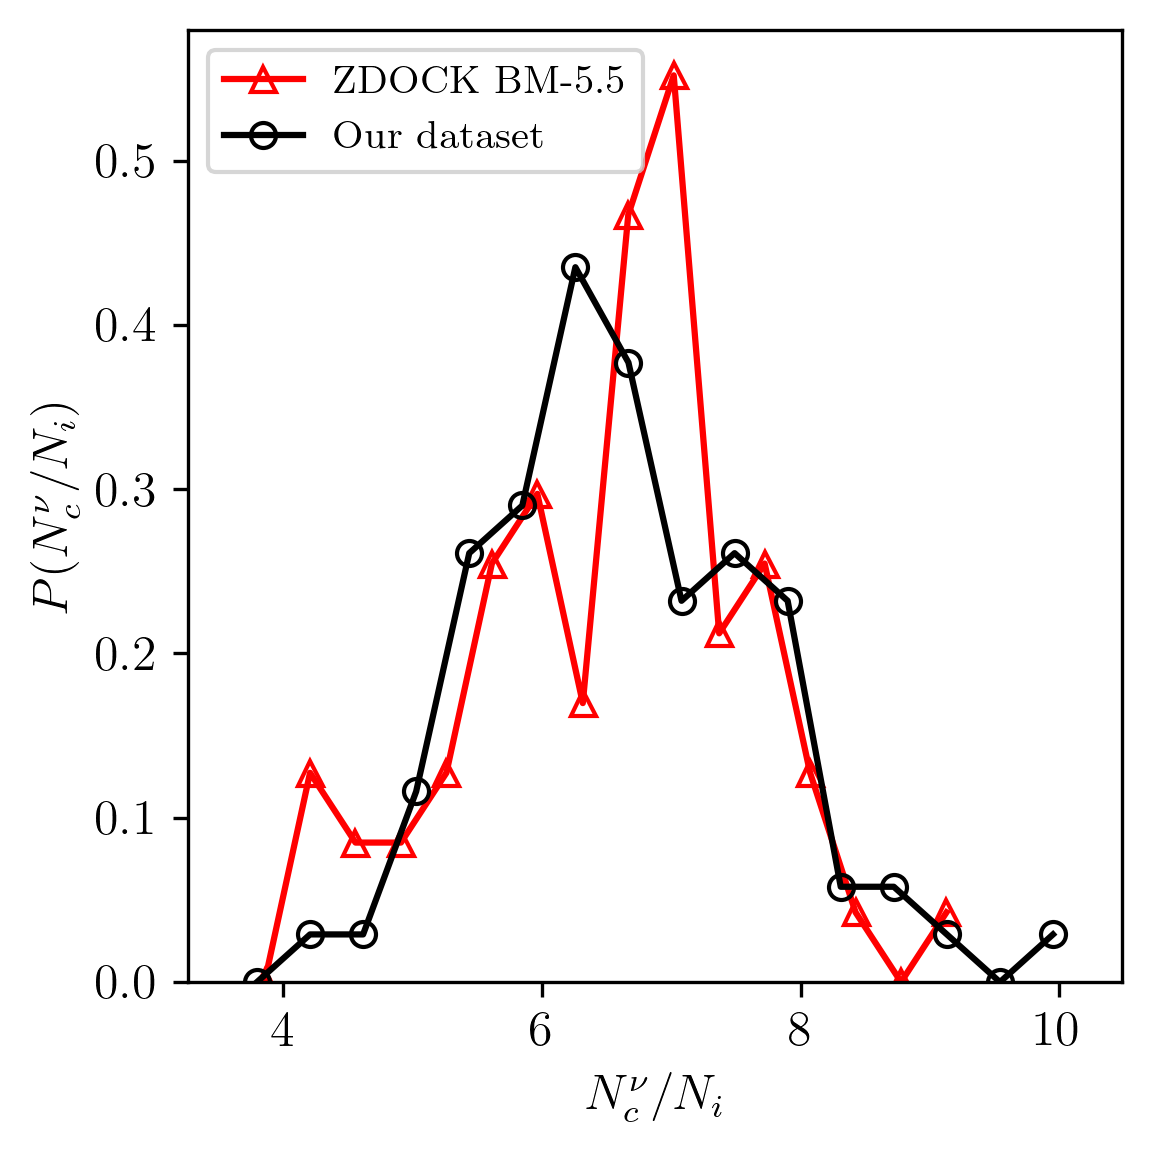

In [69]:
## plot the data

fig,ax = plt.subplots(figsize = (4,4), dpi = 300)

b55_non_unique_fracs = [frac for frac in b55_non_unique_norm.values()]
o84_non_unique_fracs = [frac for frac in o84_non_unique_norm.values()]

nbins = 15

x = create_prob_dist_identical_bins(b55_non_unique_fracs, fig, ax, color = "red", marker = "^",
                                   label = "ZDOCK BM-5.5", n_bins = nbins)

x = create_prob_dist_identical_bins(o84_non_unique_fracs, fig, ax, color = "black", marker = "o",
                                   label = "Our dataset", n_bins = nbins)



ax.set_xlabel(r"$N_c^{\nu}/N_{i}$")
ax.set_ylabel(r"$P(N_c^{\nu}/N_{i})$")

ax.legend(fontsize = 9.5)

fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"nc_prob_dist_vs_zdockbm.png"))

In [248]:
print(f"BM_55 Mean: {np.mean(b55_non_unique_fracs):0.4f}, STD: {np.std(b55_non_unique_fracs):0.4f}")
print(f"Our dataset Mean: {np.mean(o84_non_unique_fracs):0.4f}, STD: {np.std(o84_non_unique_fracs):0.4f}")

BM_55 Mean: 6.5312, STD: 1.0450
Our dataset Mean: 6.6121, STD: 1.0501


In [247]:
print(f"BM_55 Mean: {np.mean(b55_unique_fracs):0.4f}, STD: {np.std(b55_unique_fracs):0.4f}")
print(f"Our dataset Mean: {np.mean(o84_unique_fracs):0.4f}, STD: {np.std(o84_unique_fracs):0.4f}")

BM_55 Mean: 1.2128, STD: 0.1212
Our dataset Mean: 1.2140, STD: 0.1297


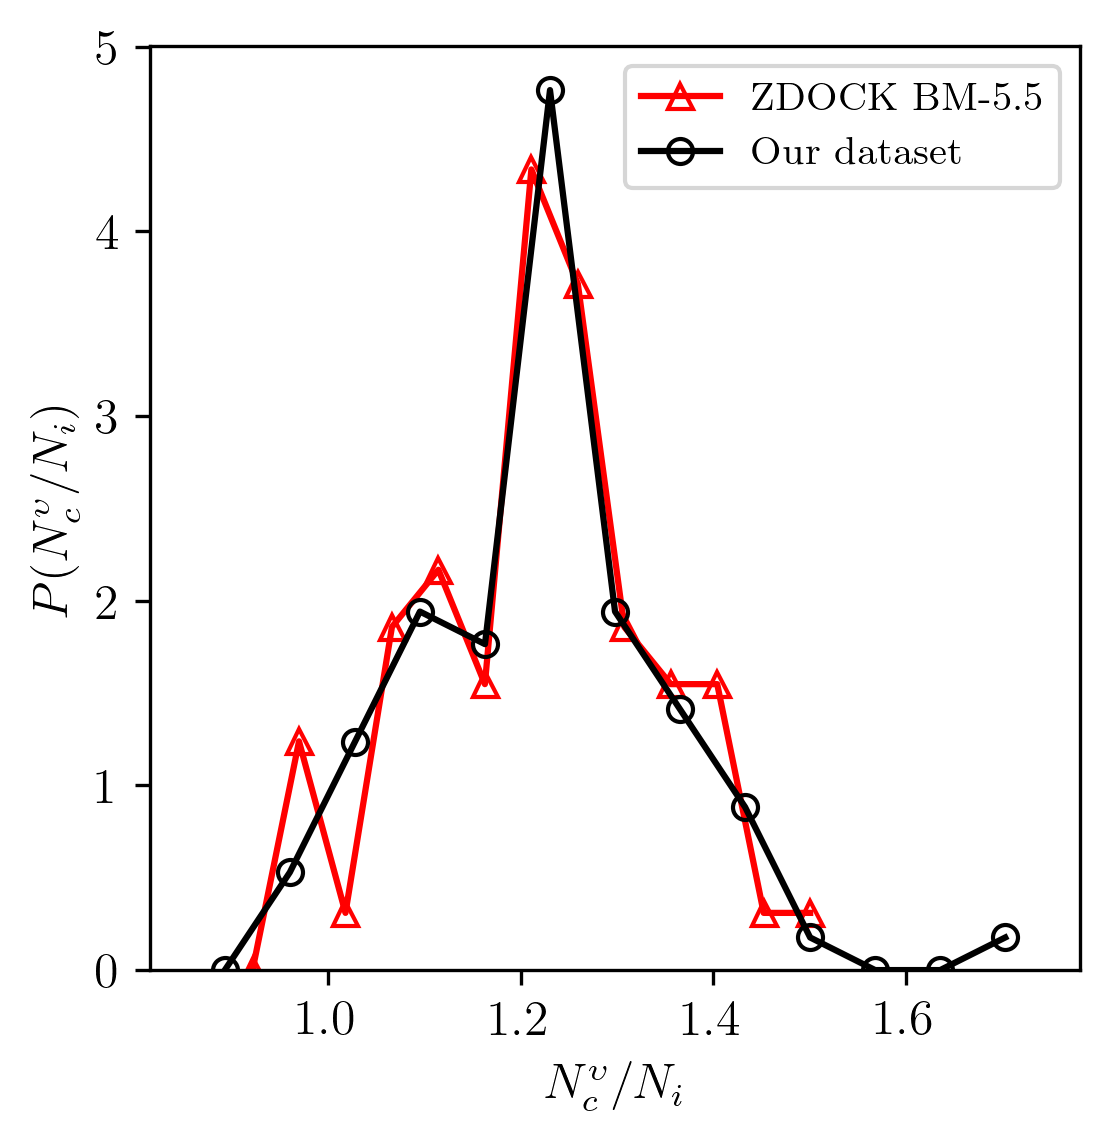

In [75]:
## plot the data

fig,ax = plt.subplots(figsize = (4,4), dpi = 300)

b55_unique_fracs = [frac for frac in b55_unique_norm.values()]
o84_unique_fracs = [frac for frac in o84_unique_norm.values()]

nbins = 12

x = create_prob_dist_identical_bins(b55_unique_fracs, fig, ax, color = "red", marker = "^",
                                   label = "ZDOCK BM-5.5", n_bins = nbins)

x = create_prob_dist_identical_bins(o84_unique_fracs, fig, ax, color = "black", marker = "o",
                                   label = "Our dataset", n_bins = nbins)



ax.set_xlabel(r"$N_c^{\upsilon}/N_{i}$")
ax.set_ylabel(r"$P(N_c^{\upsilon}/N_{i})$")

ax.legend(fontsize = 9.5)

plt.savefig(join(figure_save_dir,"nc_unique_prob_dist_vs_zdockbm.png"))

## Combine it all into a 3 panel figure

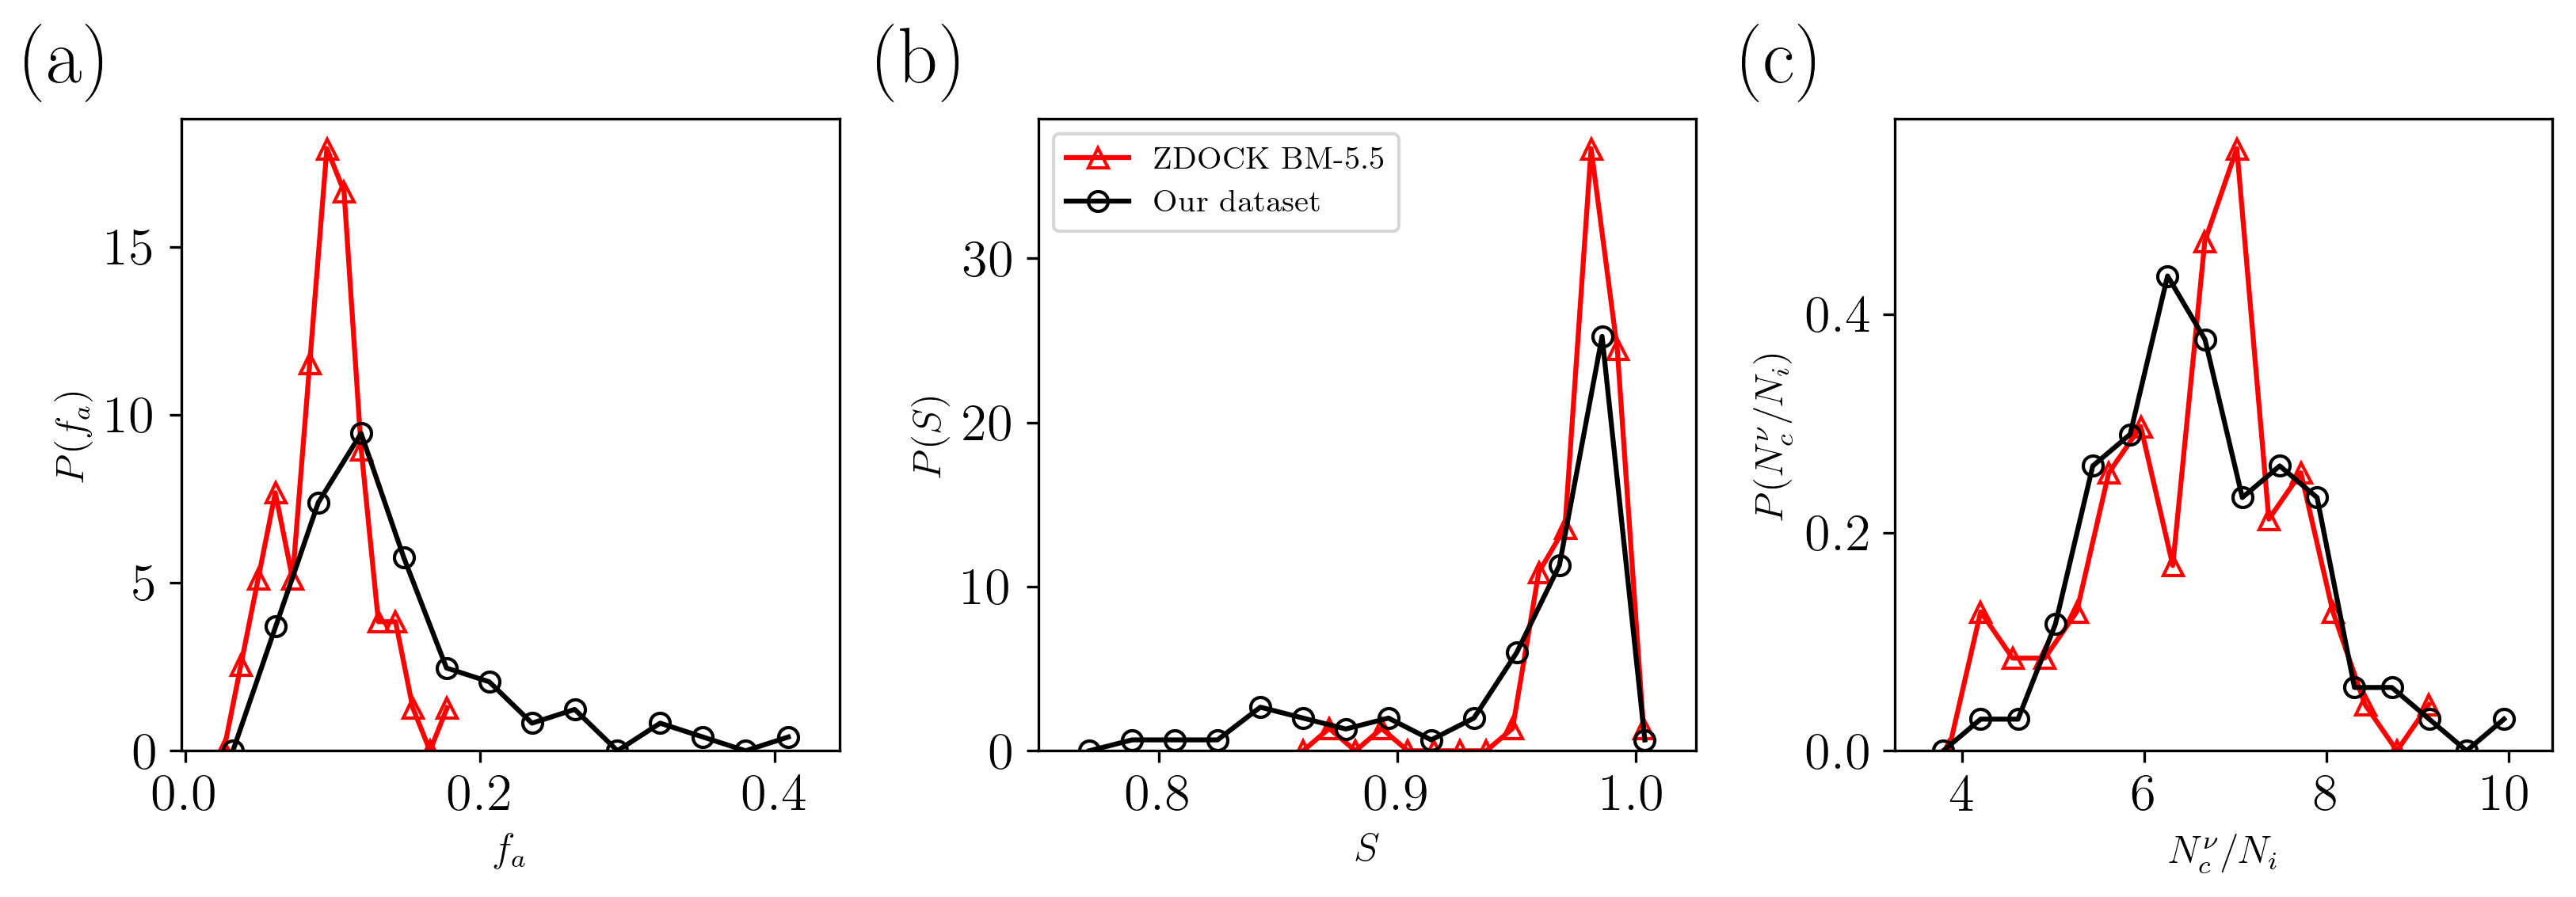

In [119]:
fig, ax = plt.subplots(1,3, figsize = (11, 4), dpi = 300)

#### Panel A ####

nbins = 13
x = create_prob_dist_identical_bins(bm_fa_df["fa"], fig, ax[0], n_bins = nbins, color = "red", marker = "^", label = "ZDOCK BM-5.5")
x = create_prob_dist_identical_bins(ss_corr_df["relative_interface_sasa"], fig, ax[0], n_bins = nbins, color = "black", marker = "o", label = "Our dataset")

ax[0].set_xlabel("$f_a$")
ax[0].set_ylabel("$P(f_a)$")



#### Panel B ####

nbins = 13
x = create_prob_dist_identical_bins(bm_55_separability["flatness_p3"], fig, ax[1], n_bins = nbins, color = "red", marker = "^", label = "ZDOCK BM-5.5")
x = create_prob_dist_identical_bins(ss_corr_df["flatness_p3"], fig, ax[1], n_bins = nbins, color = "black", marker = "o", label = "Our dataset")

ax[1].set_xlabel("$S$")
ax[1].set_ylabel("$P(S)$")


#### Panel C ####

b55_non_unique_fracs = [frac for frac in b55_non_unique_norm.values()]
o84_non_unique_fracs = [frac for frac in o84_non_unique_norm.values()]

nbins = 15

x = create_prob_dist_identical_bins(b55_non_unique_fracs, fig, ax[2], color = "red", marker = "^",
                                   label = "ZDOCK BM-5.5", n_bins = nbins)

x = create_prob_dist_identical_bins(o84_non_unique_fracs, fig, ax[2], color = "black", marker = "o",
                                   label = "Our dataset", n_bins = nbins)



ax[2].set_xlabel(r"$N_c^{\nu}/N_{i}$")
ax[2].set_ylabel(r"$P(N_c^{\nu}/N_{i})$")

ax[1].legend(fontsize = 9.5)


#### Formatting ####

letters = ['a', 'b', 'c']
for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=font_size)
    ax[i].text(-0.1, 1.15, f"({letters[i]})", transform=ax[i].transAxes,fontsize=font_size*1.5, fontweight='bold', va='top', ha='right')


fig.tight_layout()

## Save the plot to a file
plt.savefig(join(figure_save_dir,"3panel_zdock_bm_similarity.png"))


## Finishing Cross correlating everything 

First Panel
Pearson Corrlation between the two variables: (-0.7615935056499921, 4.0784282164415304e-17)
Spearman Corrlation between the two variables: SpearmanrResult(correlation=-0.8356181026627518, pvalue=4.837082324068372e-23)

First Panel
Pearson Corrlation between the two variables: (0.046575253005968376, 0.6739730439571435)
Spearman Corrlation between the two variables: SpearmanrResult(correlation=0.11416537578165156, pvalue=0.3011126959981582)

First Panel
Pearson Corrlation between the two variables: (-0.15167803695507281, 0.1684177750394091)
Spearman Corrlation between the two variables: SpearmanrResult(correlation=-0.10345351274715461, pvalue=0.34902825981139285)



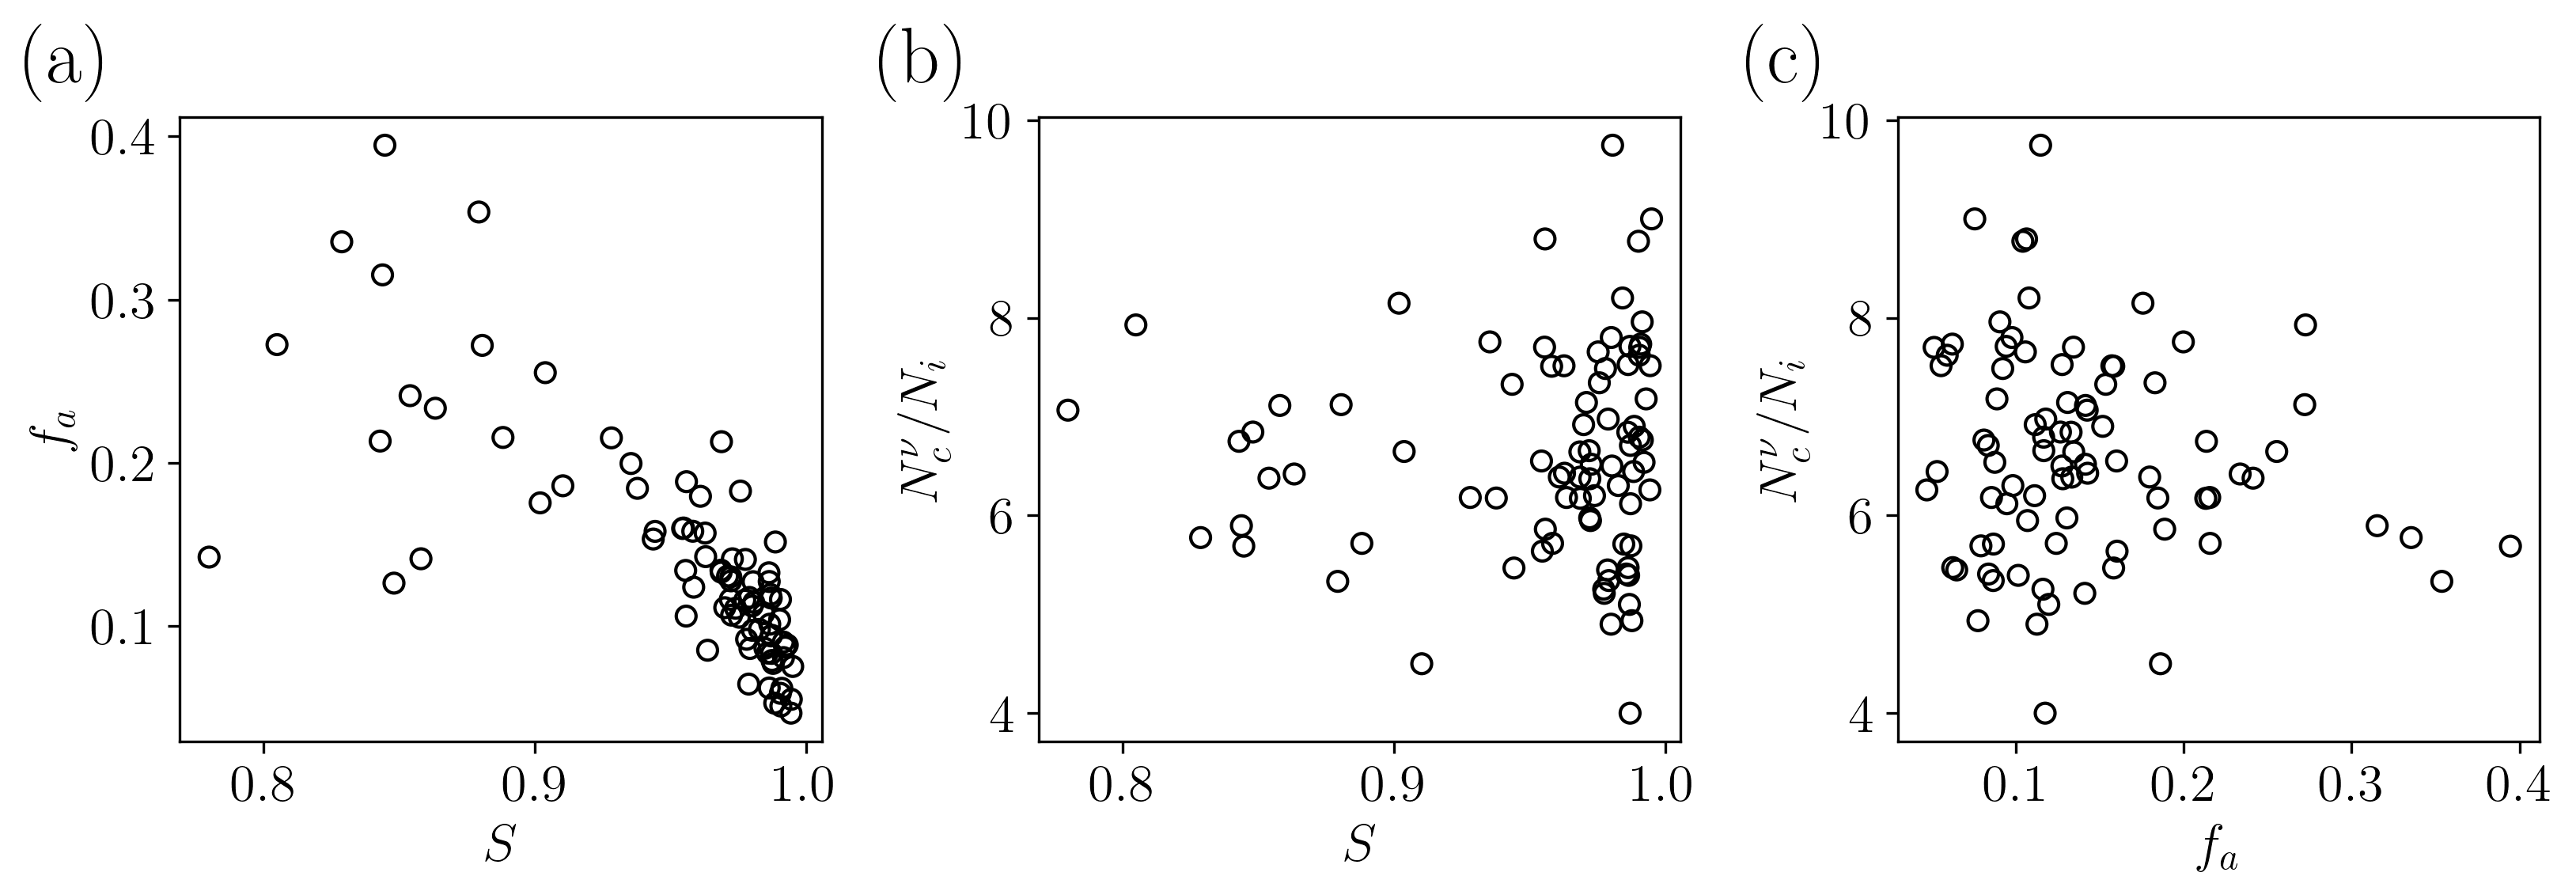

In [99]:
## Look at the values of the targets only

fig, ax = plt.subplots(1,3, figsize = (11, 4), dpi = 300)


S = ss_corr_df["flatness_p3"]
fa = ss_corr_df["relative_interface_sasa"]
nc = o84_non_unique_fracs

## First panel

ax[0].scatter(S, fa, color = "black", marker = "o", facecolor = "None")

ax[0].set_xlabel("$S$", fontsize = font_size)
ax[0].set_ylabel("$f_a$", fontsize = font_size)


## Second Panel

ax[1].scatter(S, nc, color = "black", marker = "o", facecolor = "None")

ax[1].set_xlabel("$S$", fontsize = font_size)
ax[1].set_ylabel(r"$N_c^{\nu}/N_{i}$", fontsize = font_size)

## Third Panel

ax[2].scatter(fa, nc, color = "black", marker = "o", facecolor = "None")

ax[2].set_xlabel("$f_a$", fontsize = font_size)
ax[2].set_ylabel(r"$N_c^{\nu}/N_{i}$", fontsize = font_size)


print('First Panel')
print(f"Pearson Corrlation between the two variables: {pearsonr(S, fa)}")
print(f"Spearman Corrlation between the two variables: {spearmanr(S, fa)}")
print()
print('First Panel')
print(f"Pearson Corrlation between the two variables: {pearsonr(S, nc)}")
print(f"Spearman Corrlation between the two variables: {spearmanr(S, nc)}")
print()
print('First Panel')
print(f"Pearson Corrlation between the two variables: {pearsonr(nc, fa)}")
print(f"Spearman Corrlation between the two variables: {spearmanr(nc, fa)}")
print()


letters = ['a', 'b', 'c']
for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=font_size)
    ax[i].text(-0.1, 1.15, f"({letters[i]})", transform=ax[i].transAxes,fontsize=font_size*1.5, fontweight='bold', va='top', ha='right')


fig.tight_layout()

plt.savefig(join(figure_save_dir,"cross_correlation_of_physical_features.png"))

## Now look at the same, but looking at the cross correlation between all models...

In [100]:
ss_score_dict["1acb"].columns

Index(['Decoy', 'Model', 'Fnat', 'iRMSD', 'LRMSD', 'CAPRI', 'DockQ',
       'IS-Score', 'ZRank', 'HDOCK', 'Rosetta', 'PyDock', 'VoroMQA',
       'VoroMQA_js', 'Dove_5', 'Intertwined', 'Deeprank_gnn_esm', 'Contact_42',
       'Contact_43', 'Contact_44', 'Contact_45', 'Interface_rsa', 'itscorepp',
       'ZRank Z-score', 'HDOCK Z-score', 'Rosetta Z-score', 'PyDock Z-score',
       'VoroMQA Z-score', 'VoroMQA_js Z-score', 'Dove_5 Z-score',
       'Deeprank_gnn_esm Z-score', 'itscorepp Z-score'],
      dtype='object')

Fa vs S correlation: -0.6959313996543713
Nc vs S correlation: -0.6749099987428068
Nc vs Fa correlation: 0.8525842923025257


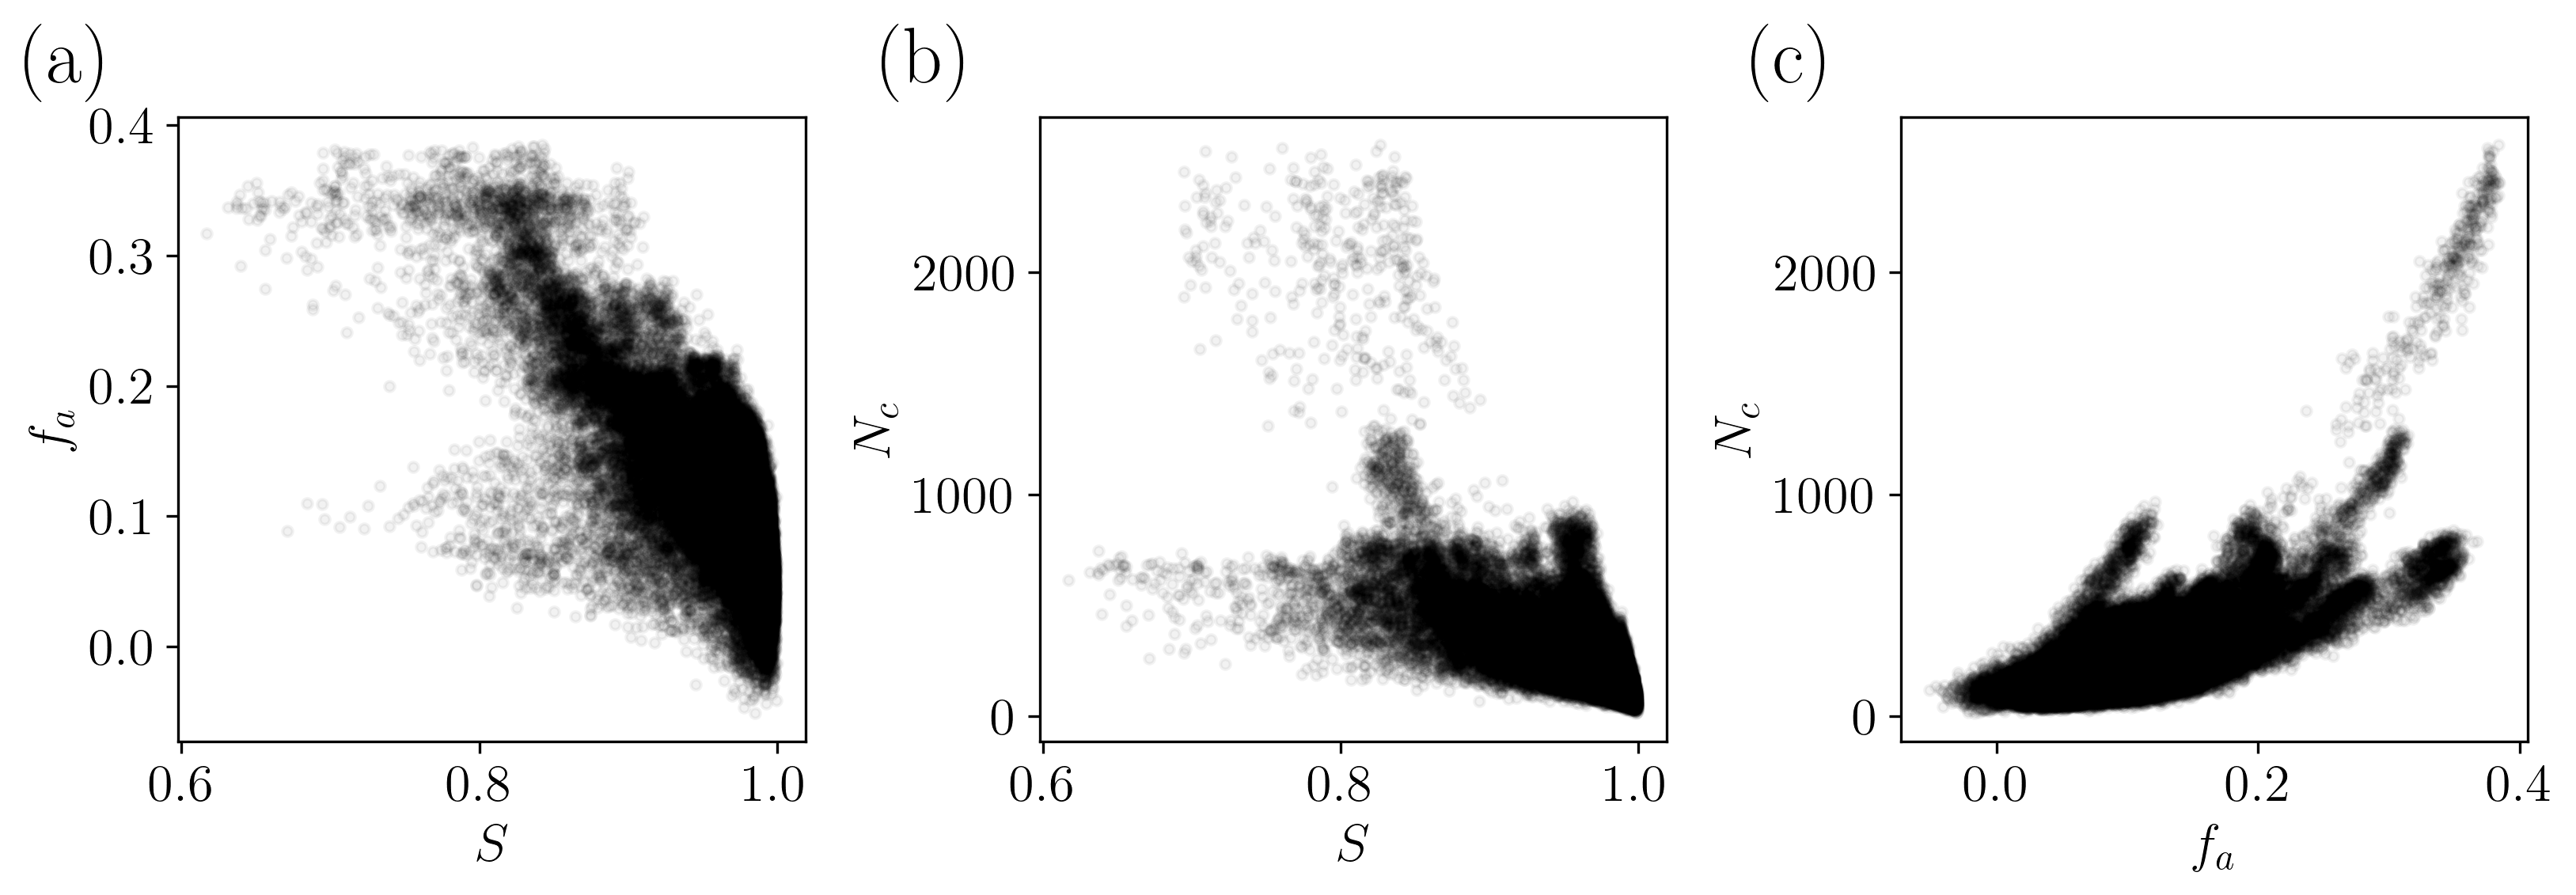

In [113]:
fig, ax = plt.subplots(1,3, figsize = (11, 4), dpi = 300)


#### Panel A #####

## Fa vs S

temp_corr_list = []

for pdb_name in list(ss_score_dict.keys()):

    temp_df = ss_score_dict[pdb_name]

    ax[0].scatter(temp_df["Intertwined"],temp_df["Interface_rsa"], color = "black", marker = ".", alpha = 0.05)

    temp_corr_list.append(pearsonr(temp_df["Intertwined"],temp_df["Interface_rsa"])[0])


print("Fa vs S correlation:", np.mean(temp_corr_list))

ax[0].set_xlabel("$S$", fontsize = font_size)
ax[0].set_ylabel("$f_a$", fontsize = font_size)
    
#### Panel B #####

## NC vs S

temp_corr_list = []

for pdb_name in list(ss_score_dict.keys()):

    temp_df = ss_score_dict[pdb_name]

    ax[1].scatter(temp_df["Intertwined"],temp_df["Contact_45"], color = "black", marker = ".", alpha = 0.05)

    temp_corr_list.append(pearsonr(temp_df["Intertwined"],temp_df["Contact_45"])[0])


print("Nc vs S correlation:", np.mean(temp_corr_list))
ax[1].set_xlabel("$S$", fontsize = font_size)
ax[1].set_ylabel(r"$N_c$", fontsize = font_size)


#### Panel C #####

## NC vs Fa

temp_corr_list = []

for pdb_name in list(ss_score_dict.keys()):

    temp_df = ss_score_dict[pdb_name]

    ax[2].scatter(temp_df["Interface_rsa"],temp_df["Contact_45"], color = "black", marker = ".", alpha = 0.05)

    temp_corr_list.append(pearsonr(temp_df["Interface_rsa"],temp_df["Contact_45"])[0])


print("Nc vs Fa correlation:", np.mean(temp_corr_list))


ax[2].set_xlabel("$f_a$", fontsize = font_size)
ax[2].set_ylabel(r"$N_c$", fontsize = font_size)


letters = ['a', 'b', 'c']
for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=font_size)
    ax[i].text(-0.1, 1.15, f"({letters[i]})", transform=ax[i].transAxes,fontsize=font_size*1.5, fontweight='bold', va='top', ha='right')


fig.tight_layout()

plt.savefig(join(figure_save_dir,"cross_correlation_of_physical_features_all_models.png"))

# PDB Overlap with the Deep learning scoring functions

## DOVE-GNN

In [120]:
fold1_label = ['1a2k', '1e96', '1he1', '1he8', '1wq1', '1f6m', '1ma9', '2btf', '1g20', '1ku6', '1t6g', '1ugh', '1yvb', '2ckh', '3pro']
fold2_label = ['1akj', '1p7q', '2bnq', '1dfj', '1nbf', '1r4m', '1xd3', '2bkr', '1gpw', '1hxy', '1u7f', '1uex', '1zy8', '2goo', '1ewy']
fold3_label = ['1avw', '1bth', '1bui', '1cho', '1ezu', '1ook', '1oph', '1ppf', '1tx6', '1xx9', '2fi4', '2kai', '1r0r', '2sni', '3sic']
fold4_label = ['1bvn', '1tmq', '1f51', '1fm9', '1a2y', '1g6v', '1gpq', '1jps', '1wej', '1l9b', '1s6v', '1w1i', '2a5t', '3fap']

all_dove_pdbs = fold1_label + fold2_label + fold3_label + fold4_label 

In [123]:
print(set(all_dove_pdbs).intersection(set(pdb_list)))

{'2bkr', '1ugh'}


In [142]:
pdb_name = "2bkr"

print(ss_corr_df[ss_corr_df["pdb"] == pdb_name]["spearman_dockq_dove_5"])

pdb_name = "1ugh"

print(ss_corr_df[ss_corr_df["pdb"] == pdb_name]["spearman_dockq_dove_5"])

24   -0.064894
Name: spearman_dockq_dove_5, dtype: float64
17    0.559986
Name: spearman_dockq_dove_5, dtype: float64


In [143]:
print(np.mean(ss_corr_df["spearman_dockq_dove_5"]))

0.11857556707933638


## Deeprank-GNN

In [125]:
## they use the Benchmark 5 dataset - 143 complexes - no Ab Ag or those with more than two chains 

In [128]:
bm_5_dir = "/Users/jakesumner/Desktop/PPI Project/Table_BM5.5.xlsx"

bm55_df = pd.read_excel(bm_5_dir)

/opt/anaconda3/envs/general_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [130]:
bm55_df = bm55_df[bm55_df["BM version introduced"] <= 5]

In [134]:
all_bm55_pdbs = []

for i in range(len(bm55_df)):

    temp_row = bm55_df.iloc[i]

    temp_name = temp_row["Complex"]

    pdb_name, chain = temp_name.split("_")

    all_bm55_pdbs.append(pdb_name.lower())

In [135]:
print(len(all_bm55_pdbs))

214


In [136]:
print(set(pdb_list).intersection(set(all_bm55_pdbs)))

{'2oul', '1ay7'}


In [141]:
pdb_name = "2oul"

print(ss_corr_df[ss_corr_df["pdb"] == pdb_name]["spearman_dockq_deeprank_gnn_esm"])

pdb_name = "1ay7"

print(ss_corr_df[ss_corr_df["pdb"] == pdb_name]["spearman_dockq_deeprank_gnn_esm"])

34    0.884483
Name: spearman_dockq_deeprank_gnn_esm, dtype: float64
1    0.839593
Name: spearman_dockq_deeprank_gnn_esm, dtype: float64


In [145]:
print(np.mean(ss_corr_df["spearman_dockq_deeprank_gnn_esm"]))
print(np.std(ss_corr_df["spearman_dockq_deeprank_gnn_esm"]))

0.6665828036466228
0.278118987161871


# Testing the sequence similarity argument of monomers - which ones are the most similar??

Plan

- Split all the dimers into their monomers and then compare the monomers via sequence similarity with Biopython.
- Those that are too similar, we look at and compare them. Maybe take them out
  

In [15]:
## Read in the monomer dataset

monomer_dir = "/Users/jakesumner/OneDrive/Desktop/protein_graph_autoencoder/pdb_targets/"

os.chdir(monomer_dir)

monomer_pdbs = glob("*_[A-Z]_H.pdb")

monomer_pdbs = sorted([filename for filename in monomer_pdbs if filename[:4] in pdb_list])

In [16]:
print(len(monomer_pdbs))

168


In [17]:
## Get the protein information (and subsequently a list of the amino acids) for each monomer

monomer_dict = {}
monomer_aa_dict = {}

for filename in monomer_pdbs:

    key_name = filename.split(".pd")[0]
    temp_df = get_protein_information(filename, monomer_dir)

    monomer_dict[key_name] = temp_df

    temp_aa_list = "".join(list(temp_df[temp_df["ca_bool"] == 1]["aa_name"]))

    monomer_aa_dict[key_name] = temp_aa_list
    
    

In [18]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

def align_two_seqs(seq1, seq2, show = False):
    '''
    Aligns two amino acid sequences and returns
    their sequence simliarity fraction
    '''

    alignments = pairwise2.align.globalxx(seq1, seq2)

    if show:
        for alignment in alignments:
            print(format_alignment(*alignment))

    alignment_score = alignments[0][2]
    aligned_seq_len = len(alignments[0][0])
    frac_similarity = alignment_score/aligned_seq_len

    return frac_similarity

In [20]:
monomer_keys = sorted(list(monomer_aa_dict.keys()))

In [21]:
similarity_matrix = np.zeros((len(monomer_keys), len(monomer_keys)))

for i, key1 in enumerate(monomer_keys):

    seq1 = monomer_aa_dict[key1]
    for j in range(i, len(monomer_keys)):
        key2 = monomer_keys[j]
        seq2 = monomer_aa_dict[key2]

        if i == j:
            similarity_matrix[i,j] = 1

        else:
            frac_similarity = align_two_seqs(seq1, seq2)
            similarity_matrix[i,j] = frac_similarity
            similarity_matrix[j,i] = frac_similarity

In [22]:
similarity_matrix

array([[1.        , 0.13011152, 0.17013889, ..., 0.15384615, 0.15492958,
        0.1875    ],
       [0.13011152, 1.        , 0.17777778, ..., 0.20175439, 0.18110236,
        0.19708029],
       [0.17013889, 0.17777778, 1.        , ..., 0.20567376, 0.20394737,
        0.19393939],
       ...,
       [0.15384615, 0.20175439, 0.20567376, ..., 1.        , 0.18382353,
        0.18243243],
       [0.15492958, 0.18110236, 0.20394737, ..., 0.18382353, 1.        ,
        0.20512821],
       [0.1875    , 0.19708029, 0.19393939, ..., 0.18243243, 0.20512821,
        1.        ]])

In [23]:
## Get each row, and then show all the PDB that exceed a certain simliarity fraction

cutoff_val = 0.9

similar_pdbs = set([])

monomer_arr = np.array(monomer_keys)
for i, key1 in enumerate(monomer_keys):

    temp_row = similarity_matrix[i, :]

    matches = monomer_arr[temp_row > cutoff_val]
    if len(matches) > 1:
        print(f"{key1[:4]}: {matches}")

        similar_pdbs.add(key1[:4])

1j7d: ['1j7d_B_H' '4dhi_D_H']
1pdk: ['1pdk_A_H' '2wmp_A_H']
1wrd: ['1wrd_B_H' '2hth_A_H' '3k9p_B_H' '7jxv_B_H']
2grn: ['2grn_A_H' '2pe6_A_H']
2hth: ['1wrd_B_H' '2hth_A_H' '3k9p_B_H' '7jxv_B_H']
2pe6: ['2grn_A_H' '2pe6_A_H']
2wmp: ['1pdk_A_H' '2wmp_A_H']
3k9p: ['1wrd_B_H' '2hth_A_H' '3k9p_B_H' '7jxv_B_H']
4dhi: ['1j7d_B_H' '4dhi_D_H']
7jxv: ['1wrd_B_H' '2hth_A_H' '3k9p_B_H' '7jxv_B_H']


In [24]:
## 4 ubiquitin containing monomers - 1wrd, 2hth, 3k9p, 7jxv
## 2 ubiquitin conjugating enzymes - 1j7d and 4dhi (E2-17) - P61088
## 2 other UBE2I SUMO conjugating enzyme - 2grn and 2pe6 - P63297
## 2 other chaperone protein PAPD - 1PDK and 2WMP
## If we were to get rid of them, then we would get rid of approximately 6 proteins

In [27]:
seq1 = monomer_aa_dict["2grn_A_H"]
seq2 = monomer_aa_dict["2pe6_A_H"]
x = align_two_seqs(seq1, seq2, show = True)

---MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIPGKKGTPWEGGLFKLRMLFKDDYPSSPPKCKFEPPLFHPNVYPSGTVCLSILEEDKDWRPAITIKQILLGIQELLNEPNIQDPAQAEAYTIYCQNRVEYEKRVRAQAKKFAP-
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 
GSHMSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIPGKKGTPWEGGLFKLRMLFKDDYPSSPPKCKFEPPLFHPNVYPSGTVCLSILEEDKDWRPAITIKQILLGIQELLNEPNIQDPAQAEAYTIYCQNRVEYEKRVRAQAKKFAPS
  Score=157



## Testing the SVR data on these protiens to see if the performance is significantly higher than average

In [188]:
ss_corr_df

Unnamed: 0   pdb  pearson_ialign_zrank  pearson_ialign_hdock  \
0            0  1acb             -0.717506             -0.572495   
1            1  1ay7             -0.804331             -0.644121   
2            2  1c3a             -0.965753             -0.961120   
3            3  1euv             -0.903749             -0.810849   
4            4  1f60             -0.934282             -0.954465   
..         ...   ...                   ...                   ...   
79          79  6zbk             -0.781797             -0.774058   
80          80  7bxh             -0.804953             -0.820440   
81          81  7joe             -0.777183             -0.849470   
82          82  7jxv             -0.619194             -0.622669   
83          83  8enf             -0.925165             -0.948351   

    pearson_ialign_rosetta  pearson_ialign_pydock  pearson_ialign_voromqa  \
0                -0.818415              -0.742908                0.774556   
1                -0.720965              -0.518193                0.524763   
2                -0.938805              -0.954437                0.768060   
3                -0.561124              -0.861152                0.159493   
4                -0.874791              -0.824968                0.788822   
..                     ...                    ...                     ...   
79               -0.835361              -0.678408                0.624669   
80               -0.814243              -0.720781                0.732772   
81               -0.664958              -0.580647                0.694228   
82               -0.477439              -0.504229                0.413785   
83               -0.874378              -0.797852                0.750706   

    pearson_ialign_voromqa_js  pearson_ialign_dove_5  \
0                    0.848402               0.564269   
1                    0.730545               0.788741   
2                    0.969857              -0.877749   
3                    0.793307               0.497068   
4                    0.839942              -0.579722   
..                        ...                    ...   
79                   0.850289               0.749478   
80                   0.929094              -0.467024   
81                   0.888198               0.623389   
82                   0.575321               0.558159   
83                   0.925741              -0.763693   

    pearson_ialign_intertwined  ...  contact_43_auc  contact_44_auc  \
0                    -0.550571  ...        0.762547        0.764547   
1                    -0.439244  ...        0.856978        0.855582   
2                    -0.791142  ...        0.984526        0.984476   
3                    -0.812000  ...        0.964044        0.962955   
4                    -0.814475  ...        0.961521        0.961780   
..                         ...  ...             ...             ...   
79                   -0.432070  ...        0.870750        0.869815   
80                   -0.319278  ...        0.934254        0.934713   
81                   -0.771127  ...        0.867603        0.869121   
82                    0.088424  ...        0.685357        0.688350   
83                   -0.656972  ...        0.965651        0.966413   

    contact_45_auc  interface_rsa_auc  itscorepp_auc  flatness_p3  resolution  \
0         0.764325           0.644104       0.772073     0.975254        2.00   
1         0.855477           0.866396       0.852197     0.986755        1.70   
2         0.985112           0.987780       0.991357     0.928116        2.50   
3         0.962283           0.955443       0.966066     0.977500        1.60   
4         0.961856           0.964506       0.971226     0.968571        1.67   
..             ...                ...            ...          ...         ...   
79        0.870923           0.903562       0.925137     0.988550        1.49   
80        0.933303           0.882509       0.937586     0.977949        2.70   
81     

In [189]:
svr_dir = "/Users/jakesumner/Desktop/PPI Project/supersampling/physical_score_svr/"

os.chdir(svr_dir)

def read_in_svr_data(svr_dir, score_dict):
    '''
    Takes the svr_dir and turns all 
    the data for all 4 kernels into a 
    df for each PDB, similar to the score
    dict. It returns the pearson and spearman
    correlations for each PDB for each 
    kernel function
    '''
    
    ## Read in all files
    svr_files = sorted([f for f in listdir(svr_dir) if isfile(join(svr_dir, f)) and "results.txt" in f])
    
    ## Init dict
    cols_to_add = ["pdb", "svr_rbf_pearson", "svr_rbf_spearman", "svr_sigmoid_pearson", "svr_sigmoid_spearman",
                  "svr_linear_pearson", "svr_linear_spearman", "svr_poly_pearson", "svr_poly_spearman",]
    final_dict = {col : [] for col in cols_to_add}
    final_score_dict = {}
    
    ## Sort files appropriately so all are in same order
    gaussian_files = sorted([f for f in svr_files if "rbf" in f])
    linear_files = sorted([f for f in svr_files if "linear" in f])
    poly_files = sorted([f for f in svr_files if "poly" in f])
    sigmoid_files = sorted([f for f in svr_files if "sigmoid" in f])
    
    ## Get Gaussian Corrs
    for tempfile in gaussian_files:
        temp_data = {"decoy" : [], "pred_y" : []}
        
        ## Isolate and add PDB to dictionary (just this time)
        curr_pdb = tempfile.split("_")[3]
        final_dict["pdb"].append(curr_pdb)
        with open(tempfile, "r") as f:
            count = 0
            for line in f:
                if curr_pdb == "3u82":
                    if count not in [359, 903]:
                        line = line.split()
                        temp_decoy = line[0]
                        temp_score = float(line[1])
                        temp_data["decoy"].append(temp_decoy)
                        temp_data["pred_y"].append(temp_score)
                    count += 1
                else:
                    line = line.split()
                    temp_decoy = line[0]
                    temp_score = float(line[1])
                    temp_data["decoy"].append(temp_decoy)
                    temp_data["pred_y"].append(temp_score)
                    count += 1
                
        ## Add data to the final_score_dict (only gaussian because it is the best)
        final_score_dict[curr_pdb] = pd.DataFrame(temp_data)
        
        ## Calculate correlations
#         if curr_pdb == "3u82":
#             print(curr_pdb, len(score_dict[curr_pdb]["DockQ"]), len(temp_data["pred_y"]))
#             for i in range(len(temp_data["decoy"])):
#                 if temp_data["decoy"][i] != list(score_dict[curr_pdb]["Decoy"])[i]:
#                     print(i, temp_data["decoy"][i], list(score_dict[curr_pdb]["Decoy"])[i], temp_data["decoy"][i+1])
#                     break
#             for i in reversed(range(len(temp_data["decoy"]))):
#                 if temp_data["decoy"][i] != list(score_dict[curr_pdb]["Decoy"])[i]:
#                     print(i, temp_data["decoy"][i], list(score_dict[curr_pdb]["Decoy"])[i], temp_data["decoy"][i])
#                     break
#             continue
        temp_pearson = pearsonr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_rbf_pearson"].append(temp_pearson)
        
        temp_spearman = spearmanr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_rbf_spearman"].append(temp_spearman)
        
    ## Get sigmoid Corrs
    for tempfile in sigmoid_files:
        temp_data = {"decoy" : [], "pred_y" : []}
        curr_pdb = tempfile.split("_")[3]
        with open(tempfile, "r") as f:
            count = 0
            for line in f:
                if curr_pdb == "3u82":
                    if count not in [359, 903]:
                        line = line.split()
                        temp_decoy = line[0]
                        temp_score = float(line[1])
                        temp_data["decoy"].append(temp_decoy)
                        temp_data["pred_y"].append(temp_score)
                    count += 1
                else:
                    line = line.split()
                    temp_decoy = line[0]
                    temp_score = float(line[1])
                    temp_data["decoy"].append(temp_decoy)
                    temp_data["pred_y"].append(temp_score)
                    count += 1
                
        ## Calculate correlations
#         print(tempfile, curr_pdb, len(temp_data["pred_y"]), len(score_dict[curr_pdb]["DockQ"]))
        temp_pearson = pearsonr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_sigmoid_pearson"].append(temp_pearson)
        
        temp_spearman = spearmanr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_sigmoid_spearman"].append(temp_spearman)
        
    ## Get linear Corrs
    for tempfile in linear_files:
        temp_data = {"decoy" : [], "pred_y" : []}
        curr_pdb = tempfile.split("_")[3]
        with open(tempfile, "r") as f:
            count = 0
            for line in f:
                if curr_pdb == "3u82":
                    if count not in [359, 903]:
                        line = line.split()
                        temp_decoy = line[0]
                        temp_score = float(line[1])
                        temp_data["decoy"].append(temp_decoy)
                        temp_data["pred_y"].append(temp_score)
                    count += 1
                else:
                    line = line.split()
                    temp_decoy = line[0]
                    temp_score = float(line[1])
                    temp_data["decoy"].append(temp_decoy)
                    temp_data["pred_y"].append(temp_score)
                    count += 1
                
        ## Calculate correlations

        temp_pearson = pearsonr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_linear_pearson"].append(temp_pearson)
        
        temp_spearman = spearmanr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_linear_spearman"].append(temp_spearman)
        
    ## Get Poly Corrs
    for tempfile in poly_files:
        temp_data = {"decoy" : [], "pred_y" : []}
        curr_pdb = tempfile.split("_")[3]
        with open(tempfile, "r") as f:
            count = 0
            for line in f:
                if curr_pdb == "3u82":
                    if count not in [359, 903]:
                        line = line.split()
                        temp_decoy = line[0]
                        temp_score = float(line[1])
                        temp_data["decoy"].append(temp_decoy)
                        temp_data["pred_y"].append(temp_score)
                    count += 1
                else:
                    line = line.split()
                    temp_decoy = line[0]
                    temp_score = float(line[1])
                    temp_data["decoy"].append(temp_decoy)
                    temp_data["pred_y"].append(temp_score)
                    count += 1
                
        ## Calculate correlations

        temp_pearson = pearsonr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_poly_pearson"].append(temp_pearson)
        
        temp_spearman = spearmanr(temp_data["pred_y"], score_dict[curr_pdb]["DockQ"])[0]
        final_dict["svr_poly_spearman"].append(temp_spearman)
        
    return pd.DataFrame(final_dict), final_score_dict

def create_ROC_data_struc_dockq(score_df, col_name = "ZRank", dockq_cutoff = 0.23):
    '''
    Takes the score_df (DataFrame) and a given 'col_name' which corresponds to one of the columns 
    in the dataframe and some quality metric, which is what treats the data as a true positive. 
    True positives are labeled with a 1 and false positives are labeled with a 0.
    '''
    
    temp_scores = score_df[col_name]
    temp_dockq = score_df["DockQ"]
    
    ## Get the label array for the capri scores
    score_mask = np.zeros(temp_dockq.size)
    for i in range(len(score_mask)):
        if temp_dockq[i] >= dockq_cutoff:
            score_mask[i] = 1
    
    return score_mask, temp_scores

def get_indiv_ROC_curve(df_dict, col_name = "ZRank", dockq_cutoff = 0.23):
    '''
    Simply aggregates all the score and label data across all targets in a dataframe and 
    then turns them into ROC curve data
    '''
    temp_keys = list(df_dict.keys())
    agg_mask = []
    agg_scores = []
    all_roc_curves = []
    all_roc_aucs = []
    for key in temp_keys:
        temp_mask, temp_scores = create_ROC_data_struc_dockq(df_dict[key], col_name = col_name, dockq_cutoff = dockq_cutoff)
        all_roc_curves.append(metrics.roc_curve(temp_mask, -1*np.array(temp_scores), pos_label=1))
        all_roc_aucs.append(metrics.roc_auc_score(temp_mask, -1*np.array(temp_scores)))
    
    return all_roc_curves, all_roc_aucs, temp_keys
        

In [190]:
## Get the SVR correlation dictionary

svr_overall_df, svr_score_dict = read_in_svr_data(svr_dir, ss_score_dict)

In [195]:
svr_data_list = []
for pdb_name in similar_pdbs:
    svr_data_list.append(svr_overall_df[svr_overall_df["pdb"] == pdb_name]["svr_rbf_pearson"].iloc[0])

In [196]:
print(svr_data_list)

[0.6581417517571917, 0.9420740933936345, 0.018499772328814893, 0.3866579591547552, 0.5922163739072777, 0.9326113845628361, 0.5811036323160776, 0.5313764169787711, 0.6014738617914098, 0.8159870661707185]


In [197]:
print(np.mean(svr_data_list))

0.6060142312361487


In [198]:
## Only ubiquitin now

ub_list = ["1wrd", "2hth", "3k9p", "7jxv"]

svr_ub_list = []
for pdb_name in ub_list:
    svr_ub_list.append(svr_overall_df[svr_overall_df["pdb"] == pdb_name]["svr_rbf_pearson"].iloc[0])

In [199]:
print(np.mean(svr_ub_list))

0.38450200256343775


In [ ]:
## 4 ubiquitin containing monomers - 1wrd, 2hth, 3k9p, 7jxv
## 2 ubiquitin conjugating enzymes - 1j7d and 4dhi (E2-17) - P61088
## 2 other UBE2I SUMO conjugating enzyme - 2grn and 2pe6 - P63297
## 2 other chaperone protein PAPD

## If we were to get rid of them, then we would get rid of 6 proteins

In [10]:
ss_corr_df[ss_corr_df["pdb"] == "1acb"]["spearman_dockq_zrank"]

0   -0.624525
Name: spearman_dockq_zrank, dtype: float64

## Querying the PDB similarity for each monomer to all PDBs and returning those with a value that is > 0.9 seq sim

- Take each monomer and do a polymer alignment of each sequence to all other sequences in the PDB.
- Save those that have similar length - length difference no greater than 4 amino acids to start! (instead of fraction)
- Save the targets that are preferably crystallized as a monomer.
- Only look at those dimers where both monomers get solid hits under these criteria

In [19]:
from rcsbsearchapi.search import SequenceQuery
from Bio import PDB
import warnings
# Suppress all warnings (including Biopython warnings)
warnings.filterwarnings("ignore")

In [20]:
## Code to query the PDB for each monomer

amino_acids = [
    # Standard amino acids
    "ALA",  # Alanine
    "ARG",  # Arginine
    "ASN",  # Asparagine
    "ASP",  # Aspartic acid
    "CYS",  # Cysteine
    "GLU",  # Glutamic acid
    "GLN",  # Glutamine
    "GLY",  # Glycine
    "HIS",  # Histidine
    "ILE",  # Isoleucine
    "LEU",  # Leucine
    "LYS",  # Lysine
    "MET",  # Methionine
    "PHE",  # Phenylalanine
    "PRO",  # Proline
    "SER",  # Serine
    "THR",  # Threonine
    "TRP",  # Tryptophan
    "TYR",  # Tyrosine
    "VAL",  # Valine
    
    # Non-canonical amino acids
    "SEC",  # Selenocysteine
    "PYL",  # Pyrrolysine
    "HYP",  # Hydroxyproline
    "MSE",  # Selenomethionine
    "ORN",  # Ornithine
    "NLE",  # Norleucine
    "DPR"   # D-Proline (mirror-image of proline)
]

def get_all_pdb_hits_for_monomer(pdb_sequence, seq_sim = 0.9, aa_dif = 10):
    '''
    Queries the PDB and returns those that are 
    similar in sequence
    '''

    results = SequenceQuery(pdb_sequence, 1, 0.98)

    sim_pdbs = []
    for polyid in results("polymer_entity"):
        sim_pdbs.append(polyid)

    ## Find the proteins with matching sequence lengths
    match_pdbs = []

    parser = PDB.PDBParser()
    pdb_list = PDB.PDBList()

    failed_pdbs = []
    
    for pdb_id in sim_pdbs:

        ## Get the pdb file

        try:
            pdb_file = pdb_list.retrieve_pdb_file(pdb_id[:4], file_format="pdb")

            ## Get the structure
    
            structure = parser.get_structure(pdb_id[:4], pdb_file)
    
            num_iter = int(pdb_id.split("_")[1])
    
            res_count = 0
    
            for model in structure:
                for chain in model:
                    for residue in chain:
                        resname = residue.get_resname()
                        if resname in amino_acids and resname not in "HOH":
                            res_count += 1
    
            # print(pdb_id, res_count, len(pdb_sequence))
    
            if abs(res_count - len(pdb_sequence)) <= aa_dif or abs(res_count - len(pdb_sequence)*2) <= aa_dif*2:
                match_pdbs.append(pdb_id)

        except:
            failed_pdbs.append(pdb_id)

    return match_pdbs, failed_pdbs
        
        

In [110]:
## Testing the code

pdb_name = "1acb_E_H"
pdb_seq = monomer_aa_dict[pdb_name]

temp_diff = 5
test_results, fails = get_all_pdb_hits_for_monomer(pdb_seq, aa_dif = temp_diff)




Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/ac/pdb1acb.ent' 
1ACB_1 304 241
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/cg/pdb1cgi.ent' 
1CGI_1 301 241
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/cg/pdb1cgj.ent' 
1CGJ_1 301 241
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/ch/pdb1chg.ent' 
1CHG_1 230 241
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/ex/pdb1ex3.ent' 
1EX3_1 245 241
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/gc/pdb1gcd.ent' 
1GCD_1 237 241
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/

In [21]:
## Getting all the results for all monomers

monomer_match_dict = {}
all_fails = []

temp_diff = 5

for monomer_name in sorted(list(monomer_aa_dict.keys())):

    pdb_seq = monomer_aa_dict[monomer_name]
    temp_results, fails = get_all_pdb_hits_for_monomer(pdb_seq, aa_dif = temp_diff)
    all_fails += fails

    monomer_match_dict[monomer_name] = temp_results

Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/ac/pdb1acb.ent' 
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/cg/pdb1cgi.ent' 
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/cg/pdb1cgj.ent' 
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/ch/pdb1chg.ent' 
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/ex/pdb1ex3.ent' 
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/gc/pdb1gcd.ent' 
Structure exists: '/Users/jakesumner/Library/CloudStorage/OneDrive-Personal/Desktop/protein_graph_autoencoder/pdb_targets/gl/pdb1gl0.ent' 
Structure exists: '/Users/j

In [22]:
import pickle

os.chdir("/Users/jakesumner/Documents/GitHub/Protein_interface_assessment/")

save_fname = "all_monomer_matches_dict.pickle"

with open(save_fname, "wb") as f:
    pickle.dump(monomer_match_dict, f)


In [42]:
pdb_84_list = ss_corr_df["pdb"]

both_monomer_matches = {}

for pdb_name in pdb_84_list:
    key_list = sorted(list(monomer_match_dict.keys()))

    temp_lists = []

    for key in key_list:
        if pdb_name in key:

            temp_matchlist = monomer_match_dict[key]

            temp_lists.append(temp_matchlist)

    if len(temp_lists[0]) > 0 and len(temp_lists[1]) > 0:
        for tmp_list in temp_lists:
            for ele in tmp_list:
                if pdb_name.upper() in ele:
                    tmp_list.remove(ele)

    ## Try again
    if len(temp_lists[0]) > 0 and len(temp_lists[1]) > 0:
        both_monomer_matches[pdb_name] = temp_lists

In [46]:
for key, value in both_monomer_matches.items():
    print(key, value)
print(len(both_monomer_matches))

1acb [['1EX3_1', '1GCD_1', '1K2I_1', '2CGA_1', '7KTY_1', '7KTZ_1', '7KU0_1', '7KU1_1', '7KU2_1', '7KU3_1', '1DLK_2', '1AB9_2', '1AFQ_2', '1GCT_2', '1GG6_2', '1GGD_2', '1GHA_2', '1GHB_2', '1GMC_2', '1GMD_2', '1GMH_2', '1VGC_2', '1YPH_2', '2CHA_2', '2GCH_2', '2GCT_2', '2GMT_2', '2P8O_2', '2VGC_2', '3GCH_2', '3GCT_2', '3VGC_2', '4CHA_2', '4GCH_2', '4VGC_2', '5CHA_2', '5GCH_2', '5R42_2', '5R44_2', '5R46_2', '5R48_2', '5R4A_2', '5R4C_2', '6CHA_2', '6GCH_2', '7GCH_2', '8GCH_2', '1AB9_3', '1GCT_3', '1GG6_3', '1GGD_3', '1GHA_3', '1GHB_3', '1GMC_3', '1GMD_3', '1GMH_3', '1VGC_3', '1YPH_3', '2CHA_3', '2GCH_3', '2GCT_3', '2GMT_3', '2P8O_3', '2VGC_3', '3GCH_3', '3GCT_3', '3VGC_3', '4CHA_3', '4GCH_3', '4VGC_3', '5CHA_3', '5GCH_3', '5R42_3', '5R44_3', '5R46_3', '5R48_3', '5R4A_3', '5R4C_3', '6CHA_3', '6GCH_3', '7GCH_3', '8GCH_3', '1AFQ_3'], ['1EGP_2']]
1ay7 [['1LNI_1', '1RGE_1', '1RGF_1', '1RGG_1', '1RGH_1', '4GHO_1', '1BOX_1', '1GMP_1', '1GMQ_1', '1GMR_1', '1I70_1', '1I8V_1', '1RSN_1', '1SAR_1', '1T

In [48]:
ss_corr_df[ss_corr_df["pdb"] == "3k9p"]["spearman_dockq_zrank"]

41   -0.389477
Name: spearman_dockq_zrank, dtype: float64

In [53]:
print(list(ss_corr_df["pdb"]))

['1acb', '1ay7', '1c3a', '1euv', '1f60', '1ggp', '1itb', '1j7d', '1kfu', '1mbv', '1n1j', '1pdk', '1qav', '1r8o', '1ry7', '1spp', '1tfo', '1ugh', '1ugq', '1vet', '1wmh', '1wqj', '1wrd', '1xg2', '2bkr', '2d5r', '2dvw', '2fhz', '2g2u', '2grn', '2h7z', '2hla', '2hsm', '2hth', '2oul', '2pe6', '2wmp', '3dgp', '3fpn', '3gfk', '3hw2', '3k9p', '3ona', '3qc8', '3qhy', '3rcz', '3sgb', '3u82', '3vz9', '3wdg', '3whq', '3ygs', '4bi8', '4ct6', '4dbg', '4dhi', '4g6t', '4gi3', '4h5s', '4hwi', '4je3', '4k12', '4qjf', '4qlp', '4u1c', '4uzz', '4yii', '5by8', '5dmb', '5k7m', '5maw', '5mu7', '5uq2', '5zrz', '6fud', '6kp3', '6wg4', '6xod', '6yxj', '6zbk', '7bxh', '7joe', '7jxv', '8enf']


In [52]:
for ele in list(ss_corr_df["pdb"]):
    print(ele)

1acb
1ay7
1c3a
1euv
1f60
1ggp
1itb
1j7d
1kfu
1mbv
1n1j
1pdk
1qav
1r8o
1ry7
1spp
1tfo
1ugh
1ugq
1vet
1wmh
1wqj
1wrd
1xg2
2bkr
2d5r
2dvw
2fhz
2g2u
2grn
2h7z
2hla
2hsm
2hth
2oul
2pe6
2wmp
3dgp
3fpn
3gfk
3hw2
3k9p
3ona
3qc8
3qhy
3rcz
3sgb
3u82
3vz9
3wdg
3whq
3ygs
4bi8
4ct6
4dbg
4dhi
4g6t
4gi3
4h5s
4hwi
4je3
4k12
4qjf
4qlp
4u1c
4uzz
4yii
5by8
5dmb
5k7m
5maw
5mu7
5uq2
5zrz
6fud
6kp3
6wg4
6xod
6yxj
6zbk
7bxh
7joe
7jxv
8enf


In [54]:
bm_55_contact_df

NameError: name 'bm_55_contact_df' is not defined

In [63]:
bm_55_pdbs = [pdb[:4].lower() for pdb in bm_55_contact_df["decoy"]]

bm_55_pdbs = list(set(bm_55_pdbs) - set(ss_corr_df["pdb"]))

In [64]:
print(bm_55_pdbs)

['1he8', '2sni', '1buh', '1nw9', '1j2j', '2c0l', '1avx', '2hrk', '3sgq', '1mah', '1tmq', '1bkd', '1r0r', '2vdb', '1e96', '1gla', '2nz8', '1jiw', '1z5y', '1zhh', '2oza', '2o8v', '1oc0', '1y64', '1ppe', '1r8s', '1kac', '1zhi', '1h1v', '2btf', '1fq1', '7cei', '1ira', '1ktz', '1m10', '1udi', '1fc2', '2o3b', '2a5t', '1d6r', '1cgi', '1fle', '2z0e', '1kxp', '1atn', '1zli', '1yvb', '2oob', '2a9k', '2ot3', '2sic', '1clv', '1us7', '2b42', '2hle', '1t6b', '2ayo', '1f34', '2uuy', '1oph', '2fju', '2g77', '1bvn', '1dfj']


In [66]:
print(len(bm_55_pdbs))

64
